**REVIEW 1**

In [ ]:
pip install catboost

     |████████████████████████████████| 67.3MB 54kB/s 


In [ ]:
# IMPORTING LIBRARIES

# General Libraries

import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from collections import Counter
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action="ignore")


# Preprocessing Libraries

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# Machine Learning Libraries

import sklearn
import xgboost as xgb
from sklearn import tree
from sklearn.svm import SVC
from sklearn.metrics import roc_curve
from imblearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report
from mlxtend.classifier import StackingCVClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import recall_score, f1_score, roc_auc_score
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score

# Defining the working directory

input_path = (r"/content/drive/MyDrive/ColabNotebooks/bankruptcy.csv")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# IMPORTING DATA

bank_data = pd.read_csv(input_path)
bank_data.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,operating gross margin,realized sales gross margin,operating profit rate,tax Pre-net interest rate,after-tax net interest rate,non-industry income and expenditure/revenue,continuous interest rate (after tax),operating expense rate,research and development expense rate,cash flow rate,interest-bearing debt interest rate,tax rate (A),per Net Share Value (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan),Operating Profit Per Share (Yuan),Per Share Net profit before tax (yuan),realized sales gross profit growth rate,operating profit growth rate,after-tax net profit growth rate,regular net profit growth rate,continuous net profit growth rate,total asset growth rate,net value growth rate,total asset return growth rate Ratio,cash reinvestment %,current ratio,quick ratio,interest expense ratio,total debt/total net worth,debt ratio %,net worth/assets,long-term fund suitability ratio (A),...,current assets/total assets,cash / total assets,Quick asset /current liabilities,cash / current liability,current liability to assets,operating funds to liability,Inventory/working capital,Inventory/current liability,current liability / liability,working capital/equity,current liability/equity,long-term liability to current assets,Retained Earnings/Total assets,total income / total expense,total expense /assets,current asset turnover rate,quick asset turnover rate,working capitcal turnover rate,cash turnover rate,Cash flow to Sales,fix assets to assets,current liability to liability,current liability to equity,equity to long-term liability,Cash flow to total assets,cash flow to liability,CFO to ASSETS,cash flow to equity,current liabilities to current assets,one if total liabilities exceeds total assets zero otherwise,net income to total assets,total assets to GNP price,No-credit interval,Gross profit to Sales,Net income to stockholder's Equity,liability to equity,Degree of financial leverage (DFL),Interest coverage ratio( Interest expense to EBIT ),one if net income was negative for the last two year zero otherwise,equity to liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256970e-04,0.0,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,...,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897850e-04,0.0,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,...,0.182419,0.014948,0.004136,1.383910e-03,0.056963,0.341106,0.289642,0.005210,0.308589,0.731975,0.329740,0.023947,0.931065,0.002226,0.025516,1.065200e-04,7.700000e+09,0.593916,2.490000e+09,0.671570,0.468828,0.308589,0.329740,0.120916,0.641100,0.459001,0.567101,0.314163,0.047775,0,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,2.361300e-04,25500000.0,0.458521,0.000790,0.0,0.177911,0.177911,0.193713,0.180581,0.307102,0.005944,0.092338,0.142803,0.022760,0.848094,0.689463,0.689470,0.217601,7.280000e+09,0.

In [ ]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   Bankrupt?                                                            6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest             6819 non-null   float64
 2    ROA(A) before interest and % after tax                              6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax                   6819 non-null   float64
 4    operating gross margin                                              6819 non-null   float64
 5    realized sales gross margin                                         6819 non-null   float64
 6    operating profit rate                                               6819 non-null   float64
 7    tax P

Now that we have an idea of our data, we need to obtain more information possible on them. The first thing that we want to understand is the nature of our data, namely if the data are numerical or categorical and if we have missing information among them. It is possible to check both these points using the *.info()* pandas method.

The resulting panel is strongly informative for us, and it shows how:

- The dataset is composed of a combination of 6819 observations per each of our 96 features.
- All of the features are numerical (int64 or float64)
- There are no missing values (Nan) among the data

Considering that all our features are numeric, we can easily calculate their descriptive statistics: a futher source of information.

In [ ]:
bank_data.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,operating gross margin,realized sales gross margin,operating profit rate,tax Pre-net interest rate,after-tax net interest rate,non-industry income and expenditure/revenue,continuous interest rate (after tax),operating expense rate,research and development expense rate,cash flow rate,interest-bearing debt interest rate,tax rate (A),per Net Share Value (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan),Operating Profit Per Share (Yuan),Per Share Net profit before tax (yuan),realized sales gross profit growth rate,operating profit growth rate,after-tax net profit growth rate,regular net profit growth rate,continuous net profit growth rate,total asset growth rate,net value growth rate,total asset return growth rate Ratio,cash reinvestment %,current ratio,quick ratio,interest expense ratio,total debt/total net worth,debt ratio %,net worth/assets,long-term fund suitability ratio (A),...,current assets/total assets,cash / total assets,Quick asset /current liabilities,cash / current liability,current liability to assets,operating funds to liability,Inventory/working capital,Inventory/current liability,current liability / liability,working capital/equity,current liability/equity,long-term liability to current assets,Retained Earnings/Total assets,total income / total expense,total expense /assets,current asset turnover rate,quick asset turnover rate,working capitcal turnover rate,cash turnover rate,Cash flow to Sales,fix assets to assets,current liability to liability,current liability to equity,equity to long-term liability,Cash flow to total assets,cash flow to liability,CFO to ASSETS,cash flow to equity,current liabilities to current assets,one if total liabilities exceeds total assets zero otherwise,net income to total assets,total assets to GNP price,No-credit interval,Gross profit to Sales,Net income to stockholder's Equity,liability to equity,Degree of financial leverage (DFL),Interest coverage ratio( Interest expense to EBIT ),one if net income was negative for the last two year zero otherwise,equity to liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,...,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,0.781381,1.995347e+09,1.950427e+09,0.467431,1.644801e+07,0.115001,0.190661,0.190633,0.190672,0.228813,0.323482,1.328641e+06,0.109091,0.184361,0.022408,0.847980,0.689146,0.689150,0.217639,5.508097e+09,1.566212e+06,0.264248,0.379677,4.032850e+05,8.376595e+06,0.630991,4.416337e+06,0.113177,0.886823,0.008783,...,0.522273,0.124095,3.592902e+06,3.715999e+07,0.090673,0.353828,0.277395,5.580680e+07,0.761599,0.735817,0.331410,5.416004e+07,0.934733,0.002549,0.029184,1.195856e+09,2.163735e+09,0.594006,2.471977e+09,0.671531,1.220121e+06,0.761599,0.331410,0.115645,0.649731,0.461849,0.593415,0.315582,0.031506,0.001173,0.807760,1.862942e+0

Despite the fact that we already know that there are no missing values (here it's pretty easy considering that we have just 96 features) it is important to computationally check that this is true, to avoid errors and time wasted in the following steps of the project.

In [ ]:
[print(col) for col in bank_data if bank_data[col].isna().sum() > 0]

[]

A further consideration needs to be done on the possibility to have duplicates in our data. Duplicates are identical observations that can create redundancy in our data and need to be dropped. Let's check the presence of duplicates to remove:

In [ ]:
bank_data.duplicated().sum()

0

Considering the project task, and now that we have a general overview of our data, we need focus our attention on the labels: which are the financially stable and unstable companies? Let's take a look:

In [ ]:
# The classes are heavily skewed we need to solve this issue later.

print(bank_data['Bankrupt?'].value_counts())
print('-'* 30)
print('Financially stable: ', round(bank_data['Bankrupt?'].value_counts()[0]/len(bank_data) * 100,2), '% of the dataset')
print('Financially unstable: ', round(bank_data['Bankrupt?'].value_counts()[1]/len(bank_data) * 100,2), '% of the dataset')


0    6599
1     220
Name: Bankrupt?, dtype: int64
------------------------------
Financially stable:  96.77 % of the dataset
Financially unstable:  3.23 % of the dataset


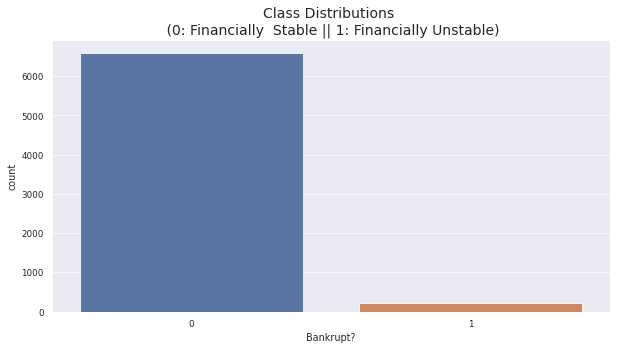

In [ ]:
sns.set_theme(context = 'paper')

plt.figure(figsize = (10,5))
sns.countplot(bank_data['Bankrupt?'])
plt.title('Class Distributions \n (0: Financially  Stable || 1: Financially Unstable)', fontsize=14)
plt.show()

Exploratory Data Analysis (EDA).

Let's explore our dataset to gain as much information as possible from several types of visualizations. A first general plot to show is the correlation heatmap that plots all the correlations (linear and non, depending on the the selected test: Pearson or Spearman) among numerical variables of the dataset. Knowing the correlations among features is an important step in deciding which features to maintain during training.

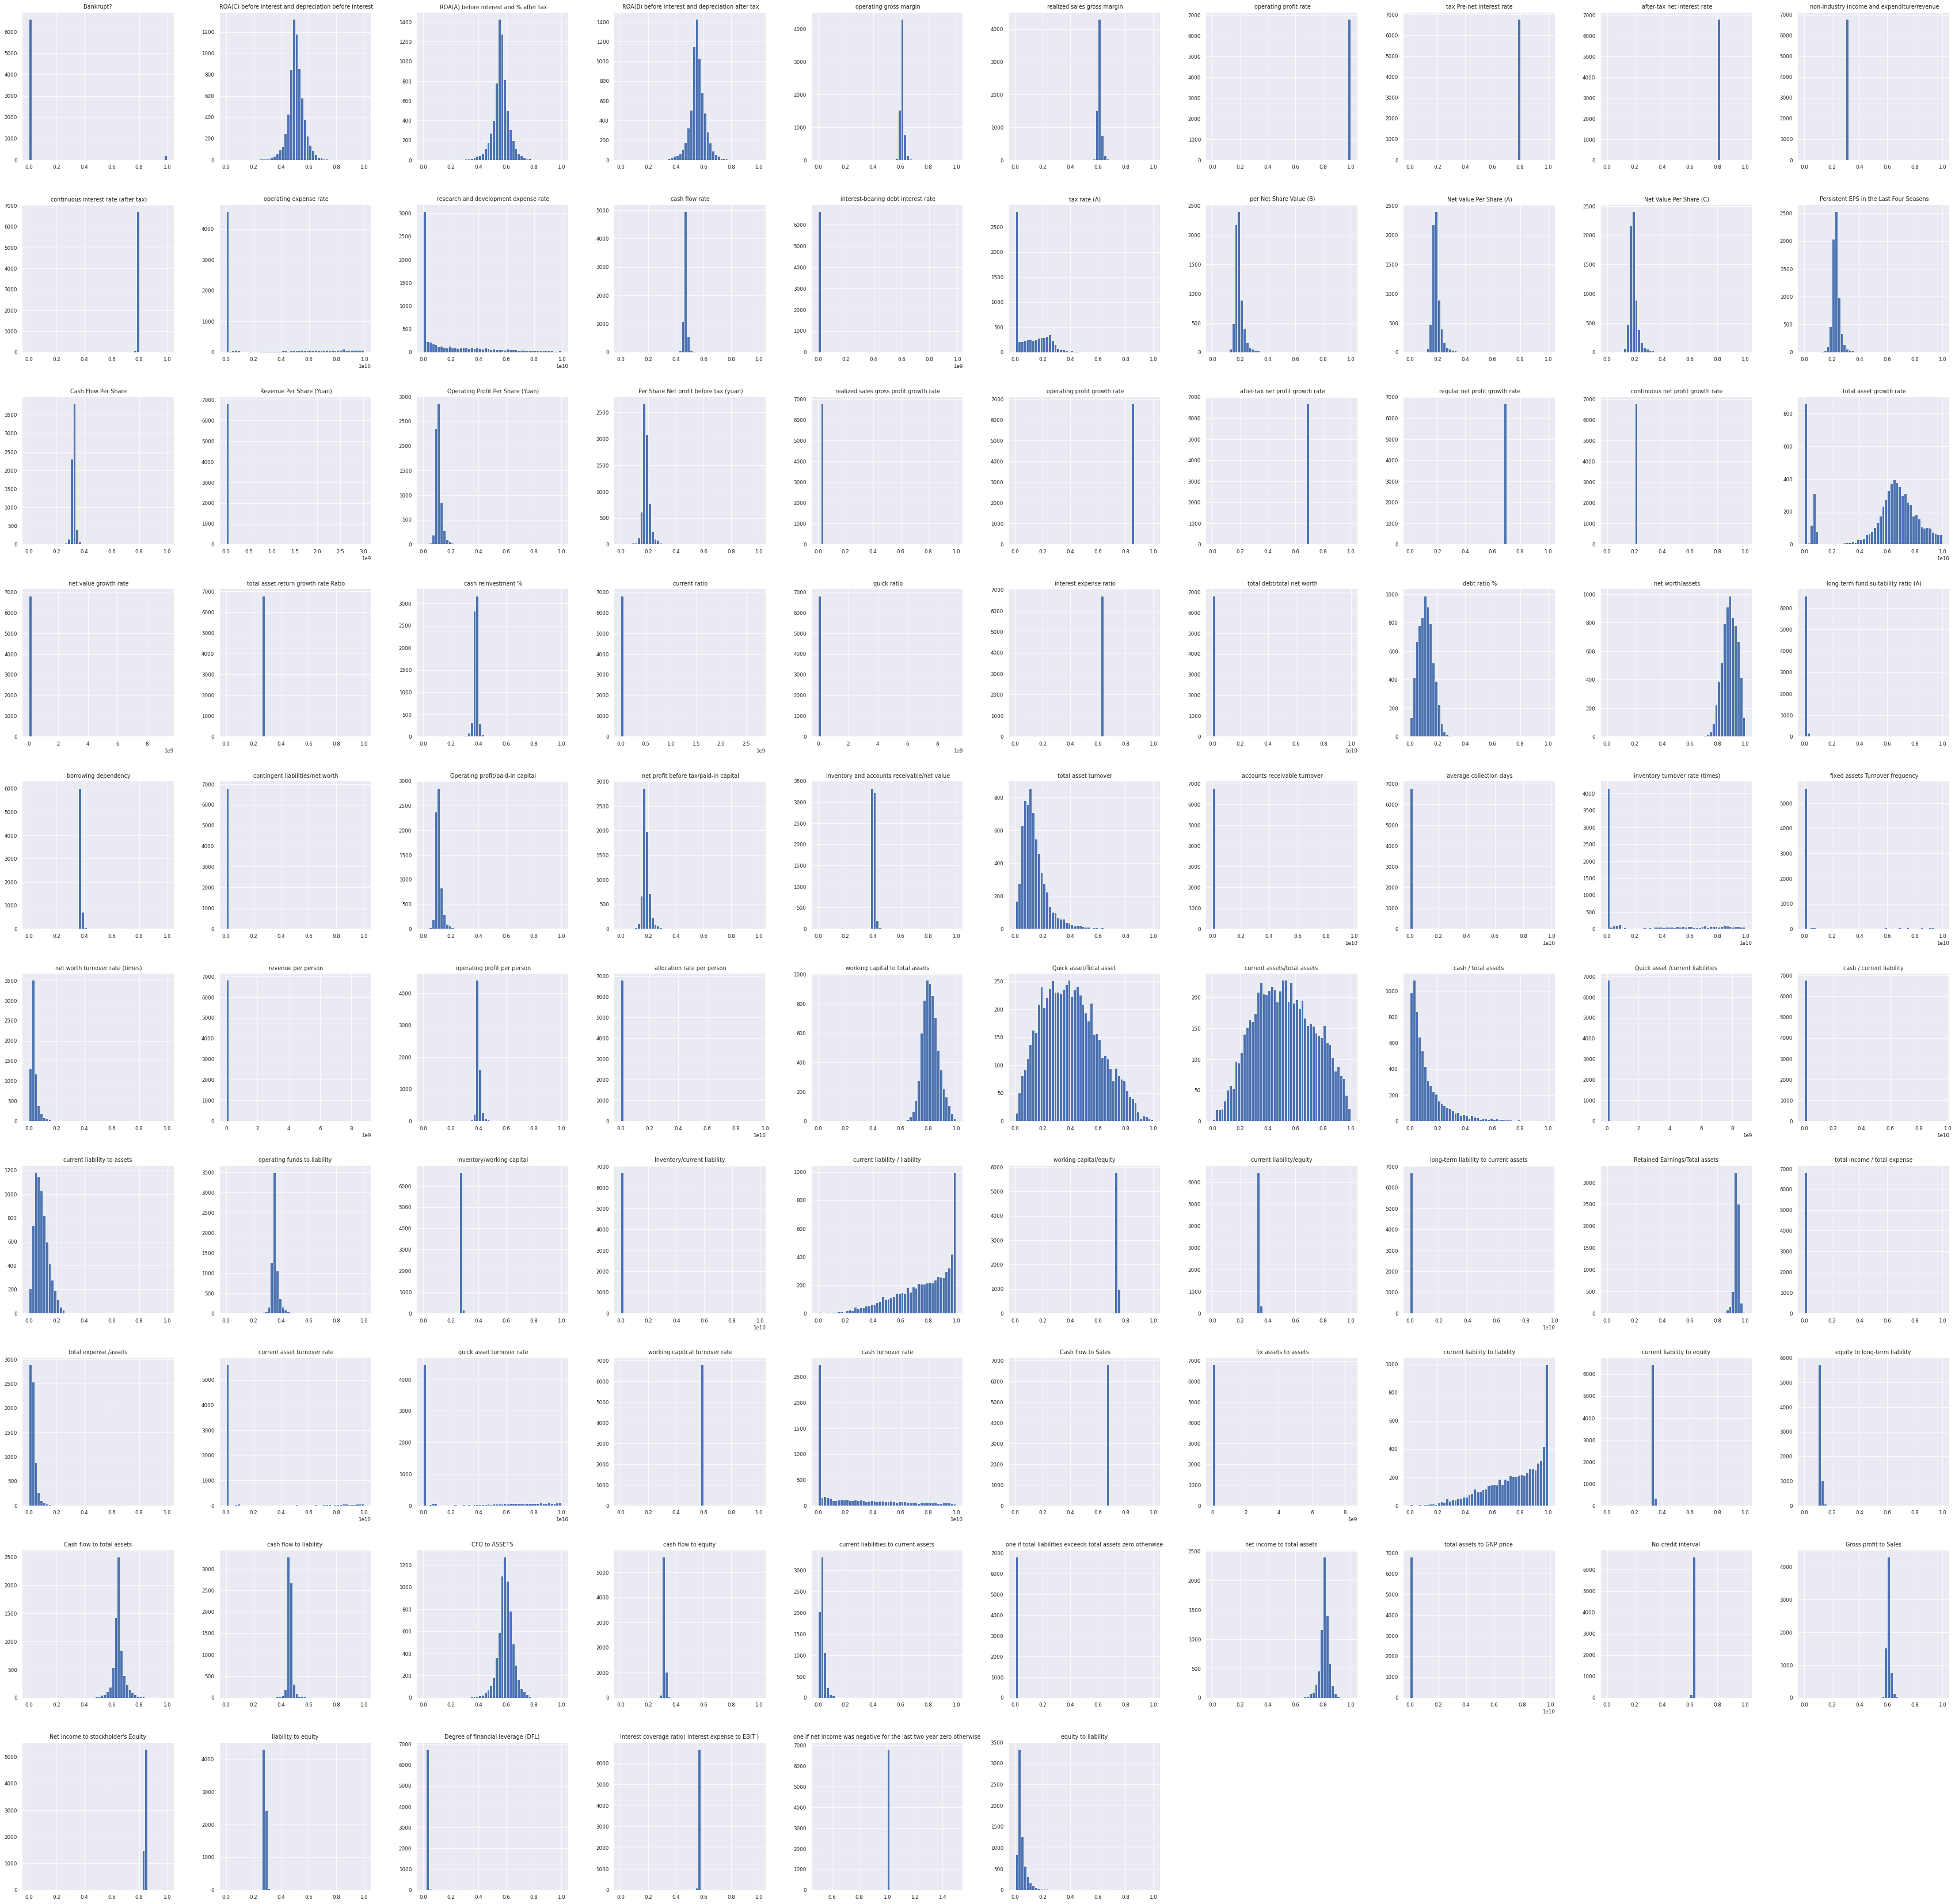

In [ ]:
# Looking at the histograms of numerical data

bank_data.hist(figsize = (60,60), bins = 50)
plt.show()

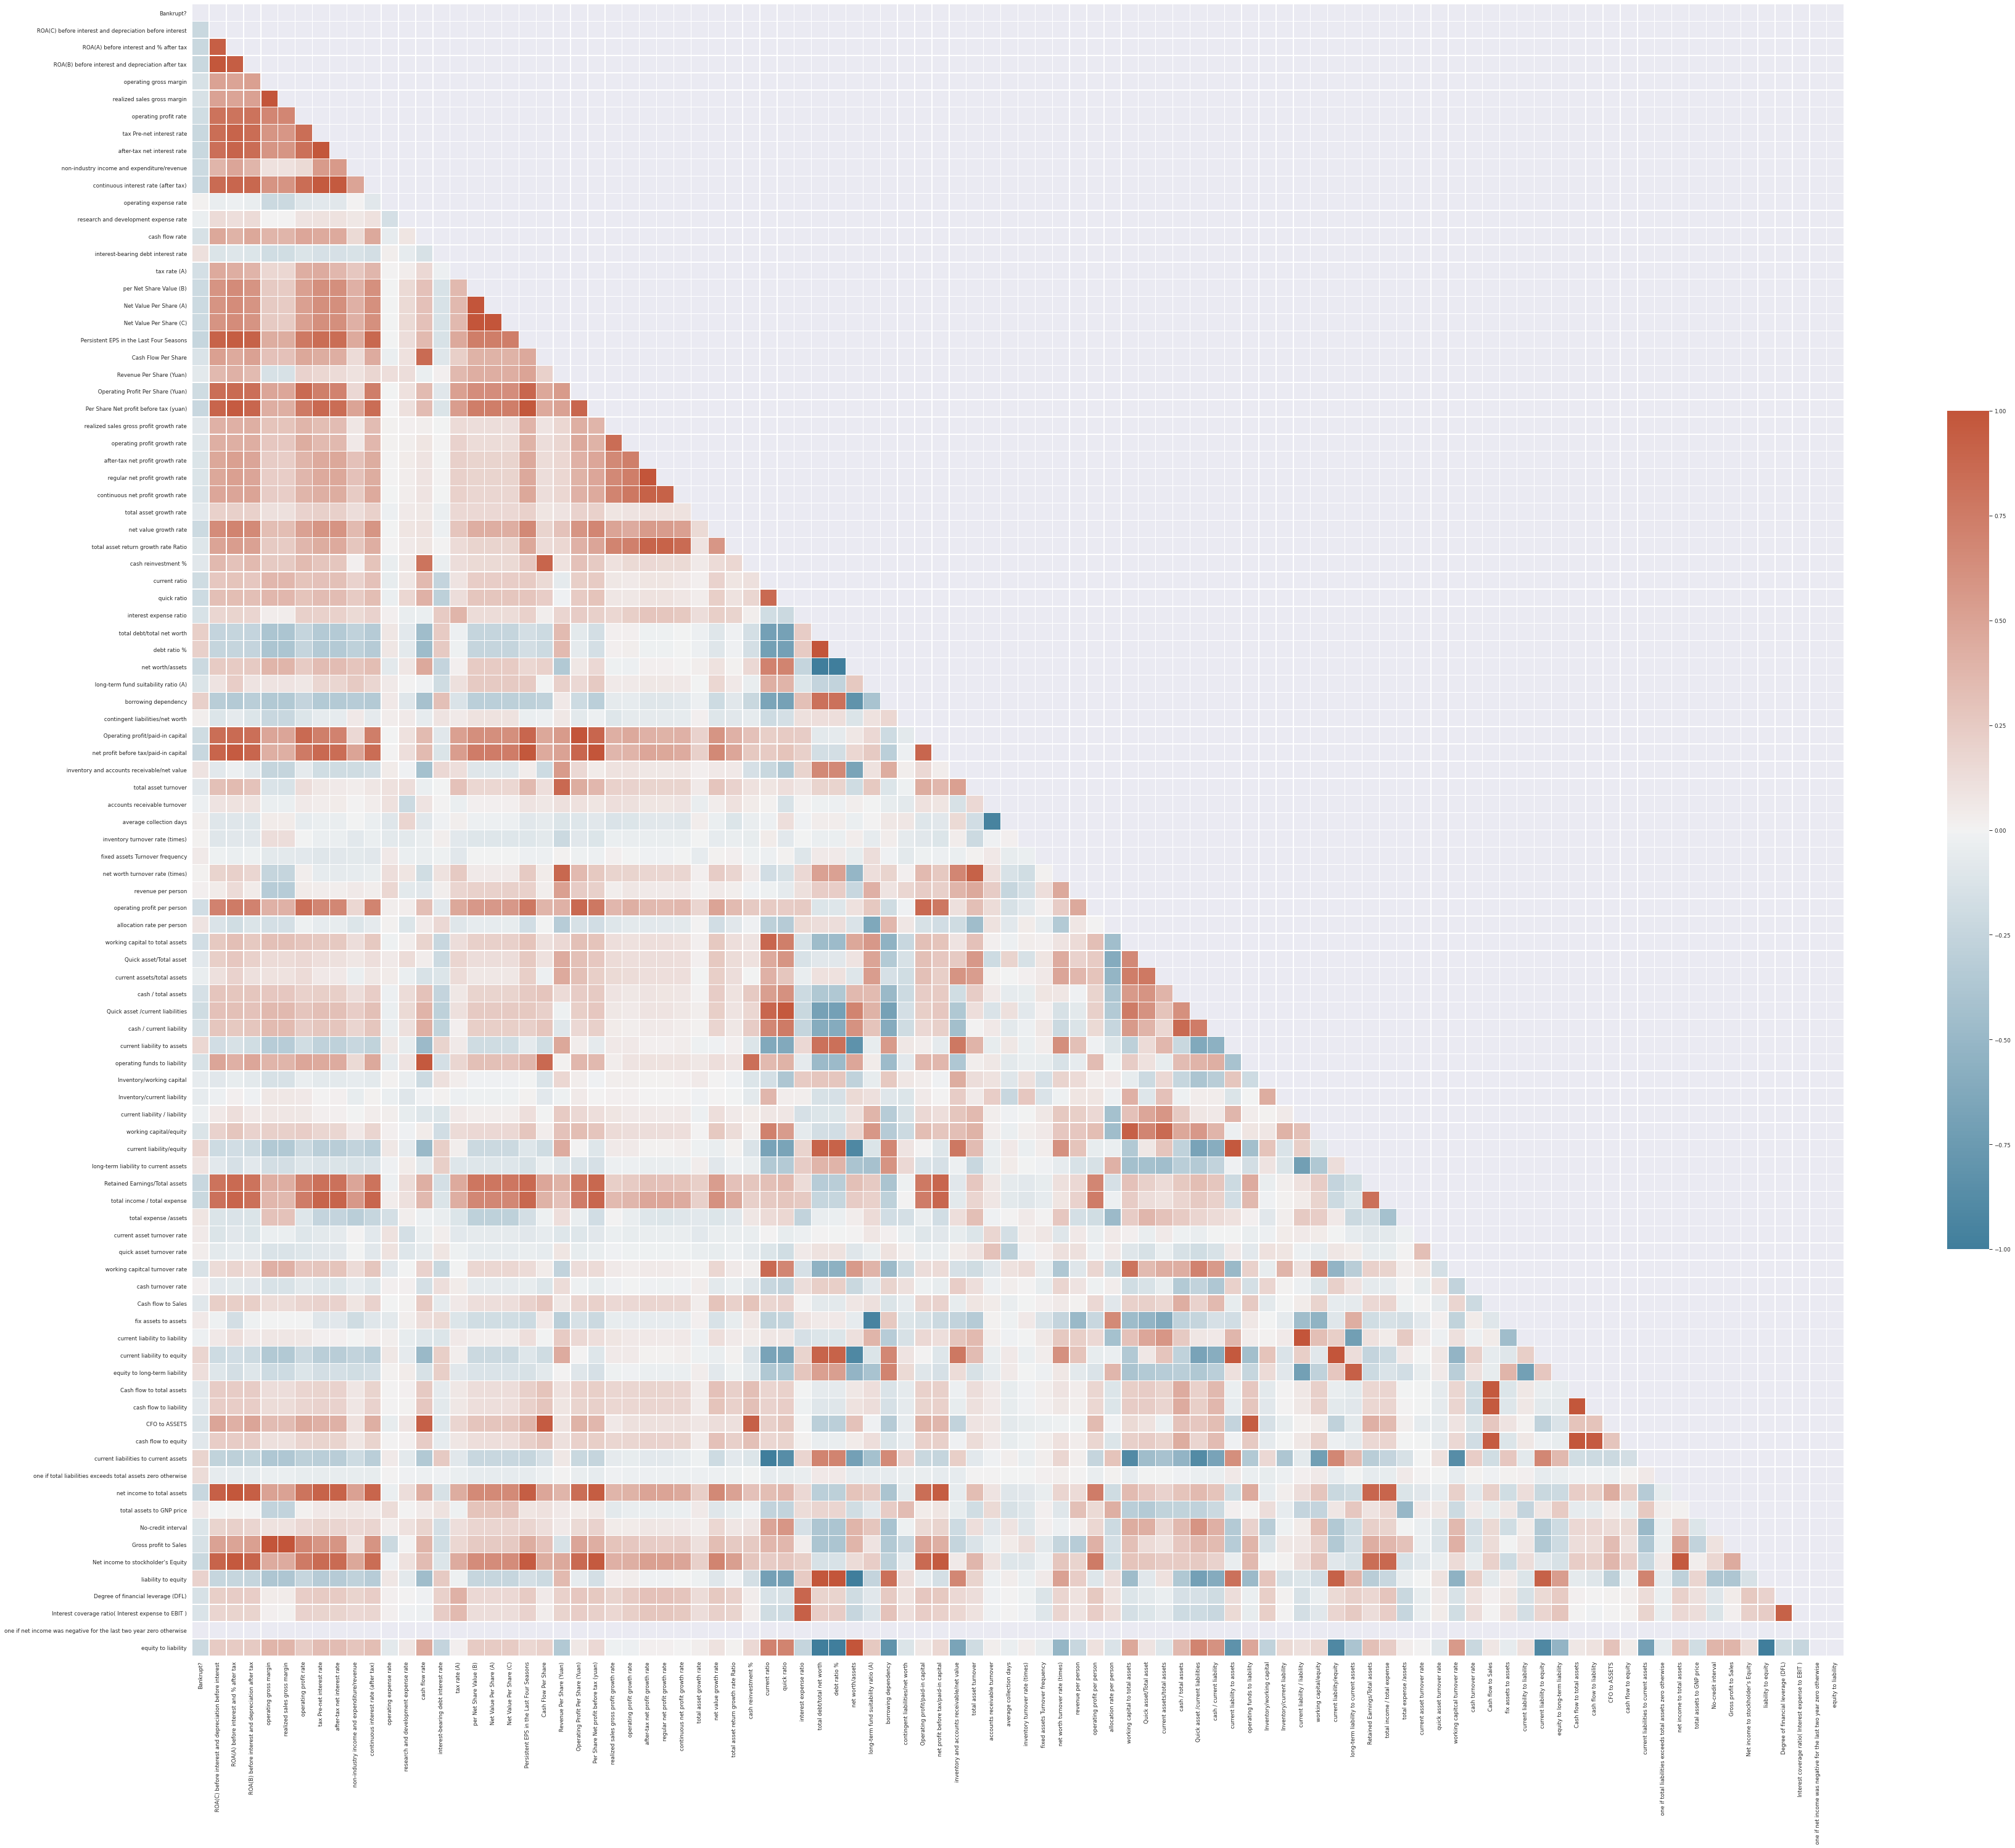

In [ ]:
# EDA & VISUALIZATIONS

# Correlation Heatmap (Spearman)

f, ax = plt.subplots(figsize=(60,50))
mat = bank_data.corr('spearman')
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0,# annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

Looking at the plot above we can clearly see how our labels are strongly unbalanced, and this is a the main obstacle that we need to solve to obtain good performances.

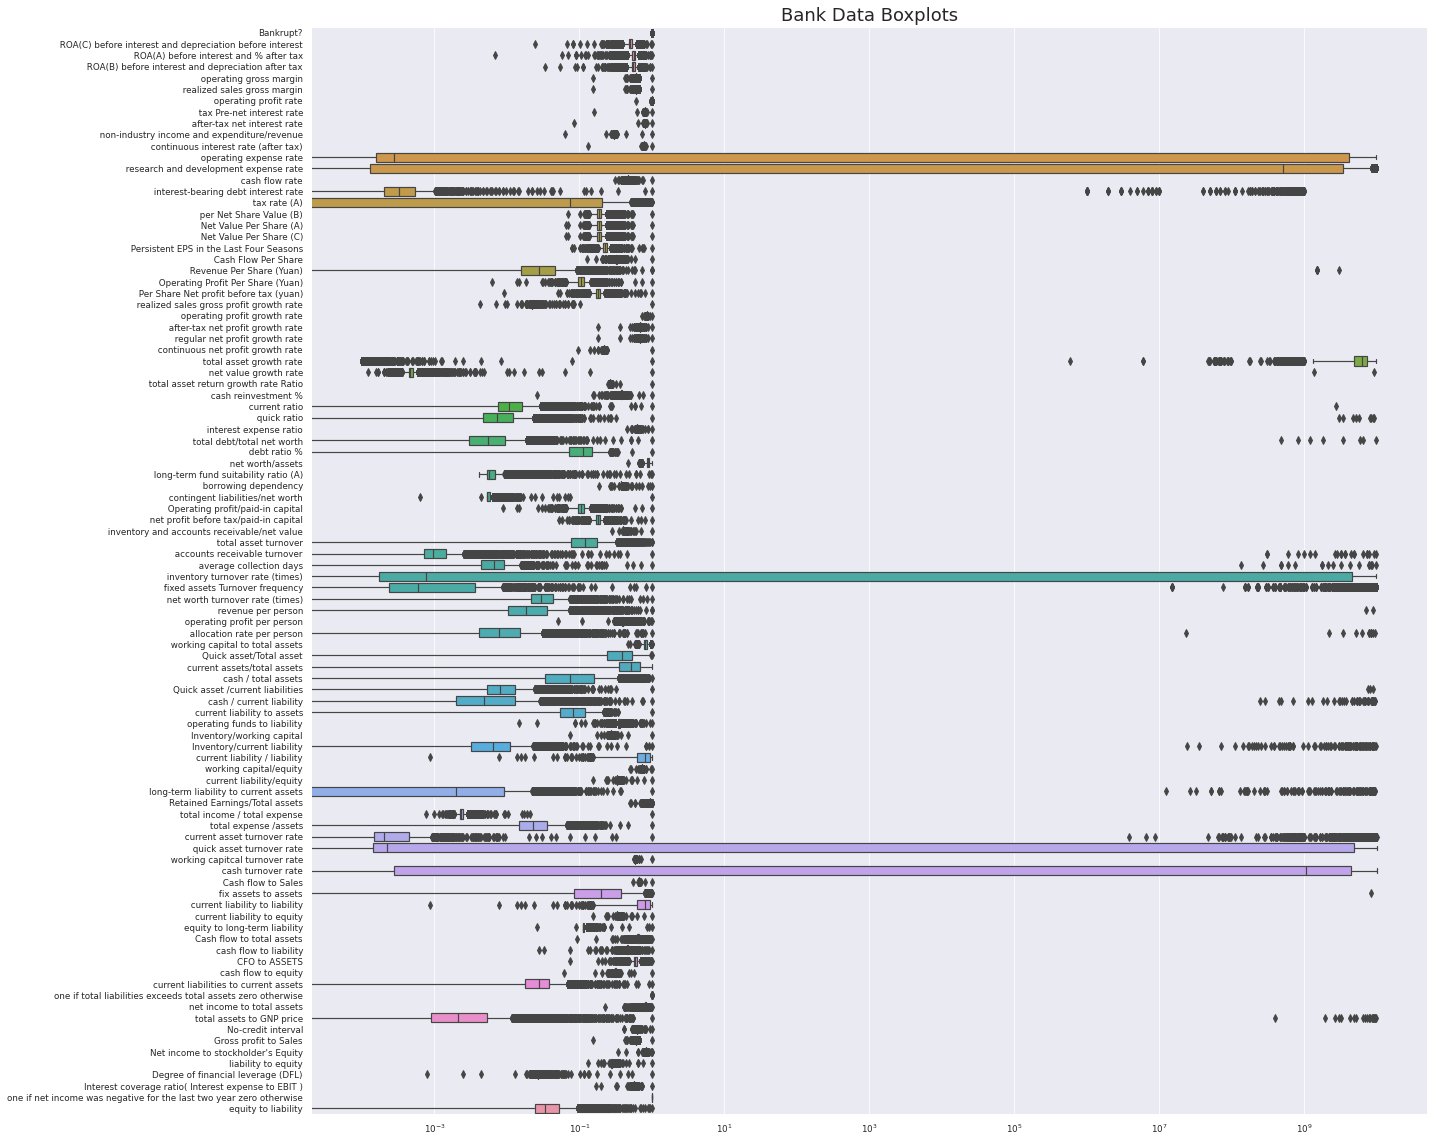

In [ ]:
# Plotting Boxplots of the numerical features

plt.figure(figsize = (20,20))
ax =sns.boxplot(data = bank_data, orient="h")
ax.set_title('Bank Data Boxplots', fontsize = 18)
ax.set(xscale="log")
plt.show()

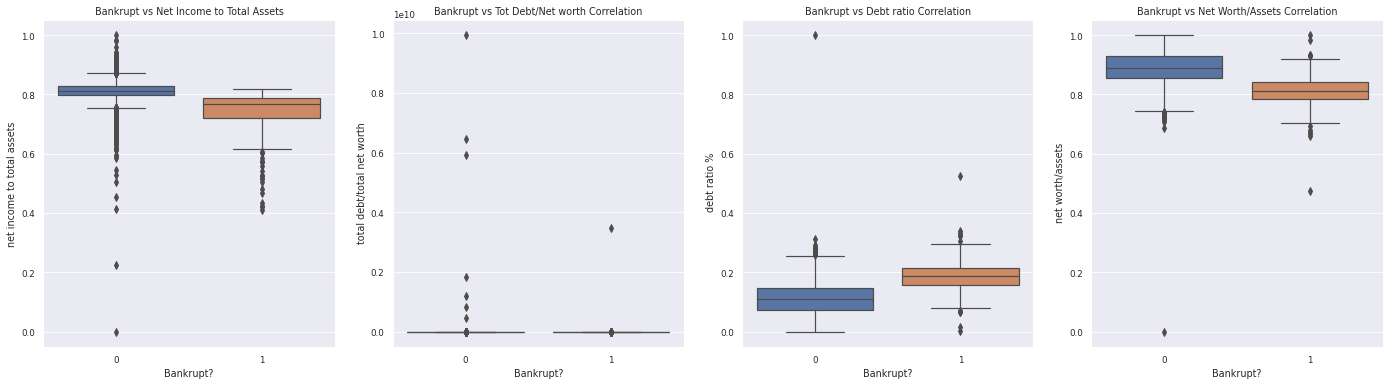

In [ ]:
# Plotting interesting features

f, axes = plt.subplots(ncols=4, figsize=(24,6))

sns.boxplot(x='Bankrupt?', y="net income to total assets", data=bank_data, ax=axes[0])
axes[0].set_title('Bankrupt vs Net Income to Total Assets')

sns.boxplot(x='Bankrupt?', y=" total debt/total net worth", data=bank_data, ax=axes[1]) 
axes[1].set_title('Bankrupt vs Tot Debt/Net worth Correlation')


sns.boxplot(x='Bankrupt?', y=" debt ratio %", data=bank_data, ax=axes[2])
axes[2].set_title('Bankrupt vs Debt ratio Correlation')


sns.boxplot(x='Bankrupt?', y=" net worth/assets", data=bank_data, ax=axes[3])  
axes[3].set_title('Bankrupt vs Net Worth/Assets Correlation') 

plt.show()

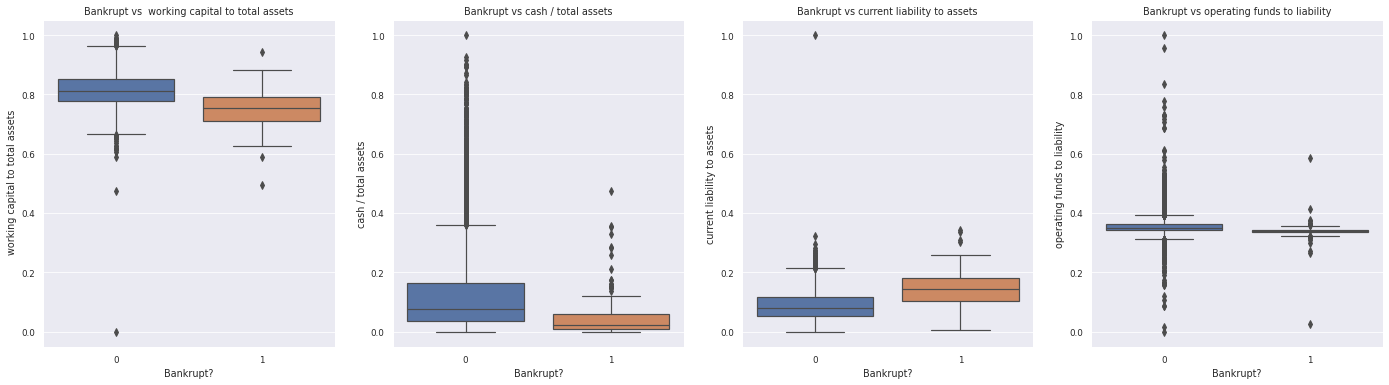

In [ ]:
# Plotting other features with an interesting correlation

f, axes = plt.subplots(ncols=4, figsize=(24,6))

sns.boxplot(x='Bankrupt?', y=" working capital to total assets", data=bank_data, ax=axes[0])
axes[0].set_title('Bankrupt vs  working capital to total assets')

sns.boxplot(x='Bankrupt?', y="cash / total assets", data=bank_data, ax=axes[1])
axes[1].set_title('Bankrupt vs cash / total assets')

sns.boxplot(x='Bankrupt?', y="current liability to assets", data=bank_data, ax=axes[2])
axes[2].set_title('Bankrupt vs current liability to assets')

sns.boxplot(x='Bankrupt?', y="operating funds to liability", data=bank_data, ax=axes[3])
axes[3].set_title('Bankrupt vs operating funds to liability')

plt.show()

Now, let's look at the distribution of these features for companies that are close to bankruptcy:

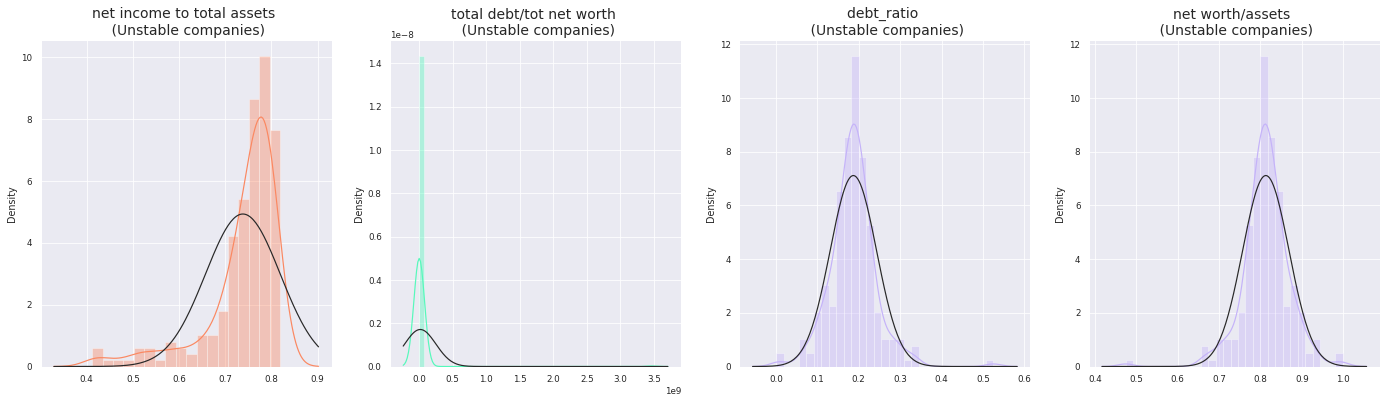

In [ ]:
# Plotting the feature distributions for close to bankrputcy companies

f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(24, 6))

cash_flow_rate = bank_data['net income to total assets'].loc[bank_data['Bankrupt?'] == 1].values
sns.distplot(cash_flow_rate,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('net income to total assets \n (Unstable companies)', fontsize=14)

tot_debt_net = bank_data[' total debt/total net worth'].loc[bank_data['Bankrupt?'] == 1].values
sns.distplot(tot_debt_net ,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('total debt/tot net worth \n (Unstable companies)', fontsize=14)

debt_ratio = bank_data[' debt ratio %'].loc[bank_data['Bankrupt?'] == 1].values
sns.distplot(debt_ratio,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('debt_ratio \n (Unstable companies)', fontsize=14)

net_worth_assets = bank_data[' net worth/assets'].loc[bank_data['Bankrupt?'] == 1].values
sns.distplot(net_worth_assets,ax=ax4, fit=norm, color='#C5B3F9')
ax4.set_title('net worth/assets \n (Unstable companies)', fontsize=14)

plt.show()

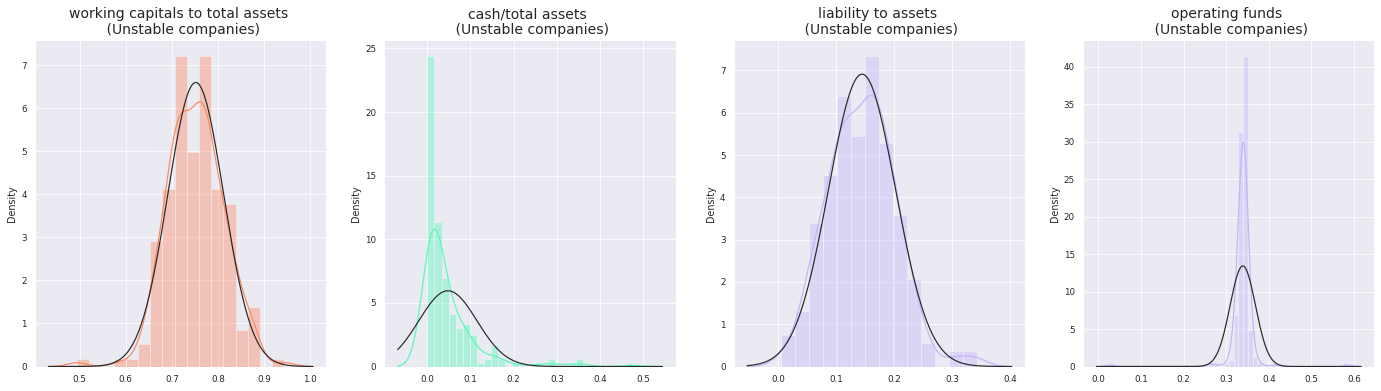

In [ ]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(24, 6))

working_cap = bank_data[' working capital to total assets'].loc[bank_data['Bankrupt?'] == 1].values
sns.distplot(working_cap,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('working capitals to total assets \n (Unstable companies)', fontsize=14)

cash_tot_assets = bank_data['cash / total assets'].loc[bank_data['Bankrupt?'] == 1].values
sns.distplot(cash_tot_assets ,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('cash/total assets \n (Unstable companies)', fontsize=14)

asset_liab = bank_data['current liability to assets'].loc[bank_data['Bankrupt?'] == 1].values
sns.distplot(asset_liab,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('liability to assets \n (Unstable companies)', fontsize=14)

operating_funds = bank_data['operating funds to liability'].loc[bank_data['Bankrupt?'] == 1].values
sns.distplot(operating_funds,ax=ax4, fit=norm, color='#C5B3F9')
ax4.set_title('operating funds \n (Unstable companies)', fontsize=14)

plt.show()


**Outliers removal**

In this part of we will try to remove the most extreme outliers (note that you can also impute them with the mean or the median instead of removing them). This should increase our models' performance. 

In [ ]:
# Outliers removal

def outliers_removal(feature,feature_name,dataset):
    
    # Identify 25th & 75th quartiles

    q25, q75 = np.percentile(feature, 25), np.percentile(feature, 75)
    print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
    feat_iqr = q75 - q25
    print('iqr: {}'.format(feat_iqr))
    
    feat_cut_off = feat_iqr * 1.5
    feat_lower, feat_upper = q25 - feat_cut_off, q75 + feat_cut_off
    print('Cut Off: {}'.format(feat_cut_off))
    print(feature_name +' Lower: {}'.format(feat_lower))
    print(feature_name +' Upper: {}'.format(feat_upper))
    
    outliers = [x for x in feature if x < feat_lower or x > feat_upper]
    print(feature_name + ' outliers for close to bankruptcy cases: {}'.format(len(outliers)))
    #print(feature_name + ' outliers:{}'.format(outliers))

    dataset = dataset.drop(dataset[(dataset[feature_name] > feat_upper) | (dataset[feature_name] < feat_lower)].index)
    print('-' * 65)
    
    return dataset

for col in bank_data:
    new_df = outliers_removal(bank_data[col],str(col),bank_data)
    

Quartile 25: 0.0 | Quartile 75: 0.0
iqr: 0.0
Cut Off: 0.0
Bankrupt? Lower: 0.0
Bankrupt? Upper: 0.0
Bankrupt? outliers for close to bankruptcy cases: 220
-----------------------------------------------------------------
Quartile 25: 0.47652708 | Quartile 75: 0.5355628139999999
iqr: 0.05903573399999995
Cut Off: 0.08855360099999993
 ROA(C) before interest and depreciation before interest Lower: 0.38797347900000007
 ROA(C) before interest and depreciation before interest Upper: 0.6241164149999998
 ROA(C) before interest and depreciation before interest outliers for close to bankruptcy cases: 391
-----------------------------------------------------------------
Quartile 25: 0.535542957 | Quartile 75: 0.5891572174999999
iqr: 0.053614260499999955
Cut Off: 0.08042139074999993
 ROA(A) before interest and % after tax Lower: 0.45512156625000005
 ROA(A) before interest and % after tax Upper: 0.6695786082499999
 ROA(A) before interest and % after tax outliers for close to bankruptcy cases: 561
---

Now, let's look at the cleaned boxplots:

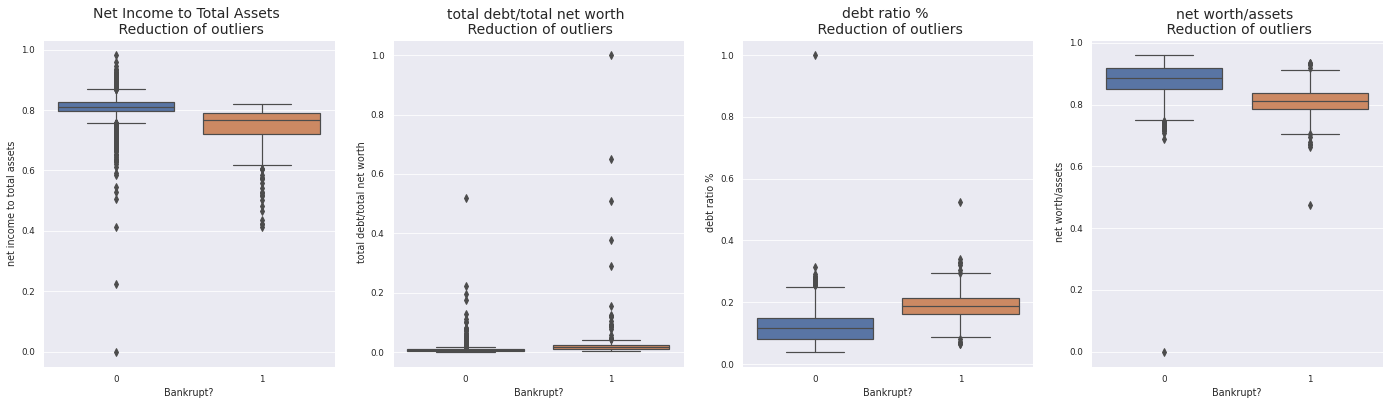

In [ ]:
f,(ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24,6))

# Boxplots with outliers removed

sns.boxplot(x="Bankrupt?", y="net income to total assets", data=new_df,ax=ax1) 
ax1.set_title("Net Income to Total Assets \n Reduction of outliers", fontsize=14)

sns.boxplot(x="Bankrupt?", y=" total debt/total net worth", data=new_df,ax=ax2) 
ax2.set_title("total debt/total net worth \n Reduction of outliers", fontsize=14)

sns.boxplot(x="Bankrupt?", y=" debt ratio %", data=new_df,ax=ax3) 
ax3.set_title("debt ratio % \n Reduction of outliers", fontsize=14)

sns.boxplot(x="Bankrupt?", y=' net worth/assets', data=new_df,ax=ax4) 
ax4.set_title("net worth/assets \n Reduction of outliers", fontsize=14)
        
plt.show()

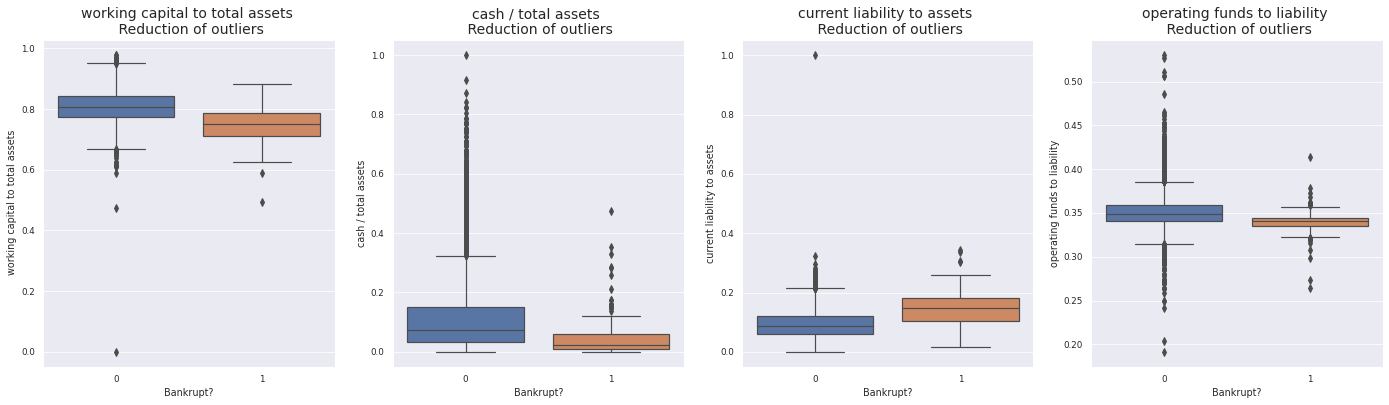

In [ ]:
f,(ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24,6))

# Boxplots with outliers removed

sns.boxplot(x="Bankrupt?", y=' working capital to total assets', data=new_df,ax=ax1) 
ax1.set_title("working capital to total assets \n Reduction of outliers", fontsize=14)

sns.boxplot(x="Bankrupt?", y='cash / total assets', data=new_df,ax=ax2) 
ax2.set_title("cash / total assets \n Reduction of outliers", fontsize=14)

sns.boxplot(x="Bankrupt?", y='current liability to assets', data=new_df,ax=ax3) 
ax3.set_title("current liability to assets \n Reduction of outliers", fontsize=14)

sns.boxplot(x="Bankrupt?", y='operating funds to liability', data=new_df,ax=ax4) 
ax4.set_title("operating funds to liability \n Reduction of outliers", fontsize=14)
        
plt.show()

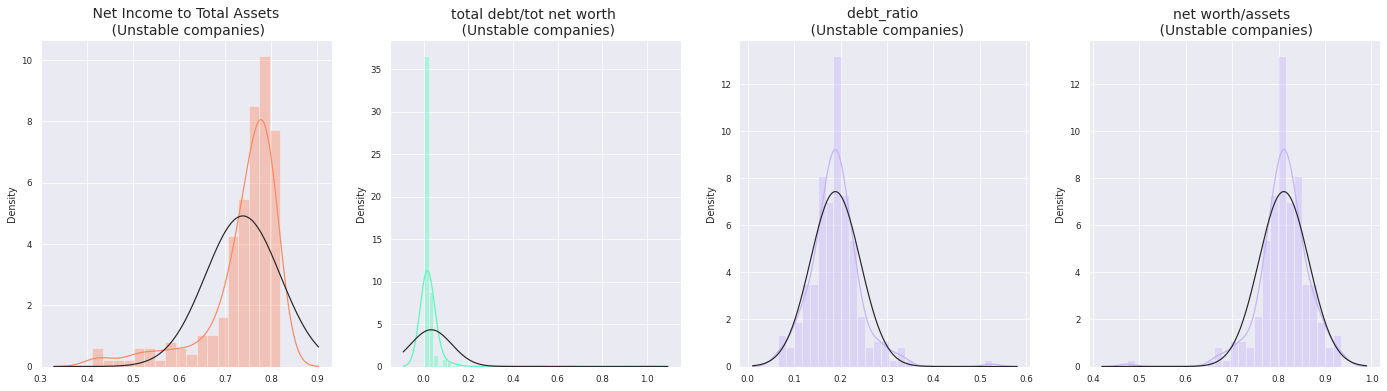

In [ ]:
# Plotting the feature distributions for close to bankrputcy companies

f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(24, 6))

cash_flow_rate = new_df['net income to total assets'].loc[new_df['Bankrupt?'] == 1].values
sns.distplot(cash_flow_rate,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title(' Net Income to Total Assets \n (Unstable companies)', fontsize=14)

tot_debt_net = new_df[' total debt/total net worth'].loc[new_df['Bankrupt?'] == 1].values
sns.distplot(tot_debt_net ,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('total debt/tot net worth \n (Unstable companies)', fontsize=14)


debt_ratio = new_df[' debt ratio %'].loc[new_df['Bankrupt?'] == 1].values
sns.distplot(debt_ratio,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('debt_ratio \n (Unstable companies)', fontsize=14)

net_worth_assets = new_df[' net worth/assets'].loc[new_df['Bankrupt?'] == 1].values
sns.distplot(net_worth_assets,ax=ax4, fit=norm, color='#C5B3F9')
ax4.set_title('net worth/assets \n (Unstable companies)', fontsize=14)

plt.show()

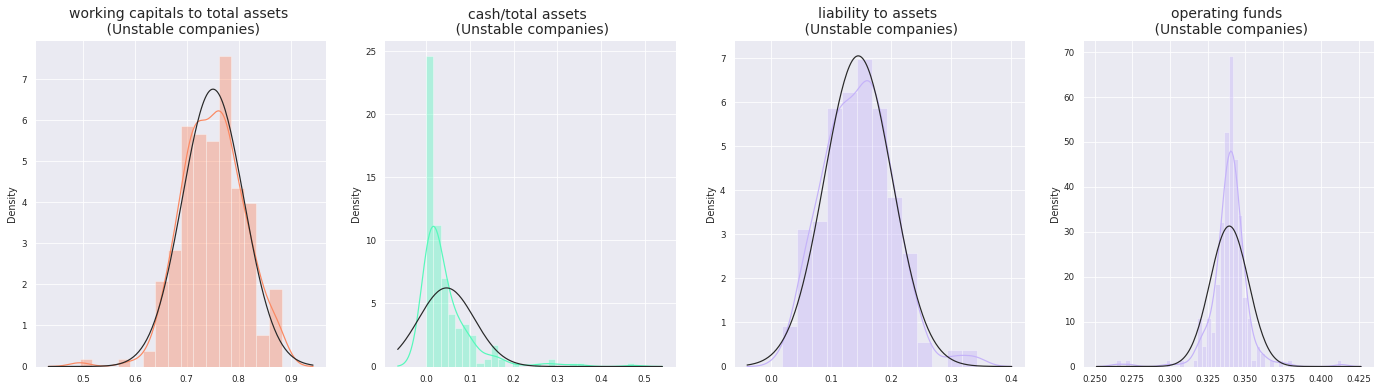

In [ ]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(24, 6))

working_cap = new_df[' working capital to total assets'].loc[new_df['Bankrupt?'] == 1].values
sns.distplot(working_cap,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('working capitals to total assets \n (Unstable companies)', fontsize=14)

cash_tot_assets = new_df['cash / total assets'].loc[new_df['Bankrupt?'] == 1].values
sns.distplot(cash_tot_assets ,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('cash/total assets \n (Unstable companies)', fontsize=14)


asset_liab = new_df['current liability to assets'].loc[new_df['Bankrupt?'] == 1].values
sns.distplot(asset_liab,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('liability to assets \n (Unstable companies)', fontsize=14)

operating_funds = new_df['operating funds to liability'].loc[new_df['Bankrupt?'] == 1].values
sns.distplot(operating_funds,ax=ax4, fit=norm, color='#C5B3F9')
ax4.set_title('operating funds \n (Unstable companies)', fontsize=14)

plt.show()

What we can see is that removing the extreme outliers definitely helps to obtain more "bell shape" distributions!(At least for the features showed)

In [ ]:
# Dividing Data and Labels

labels = new_df['Bankrupt?']
new_df = new_df.drop(['Bankrupt?'], axis = 1)

In [ ]:
def log_trans(data):
    
    for col in data:
        skew = data[col].skew()
        if skew > 0.5 or skew < -0.5:
            data[col] = np.log1p(data[col])
        else:
            continue
            
    return data

data_norm = log_trans(new_df)

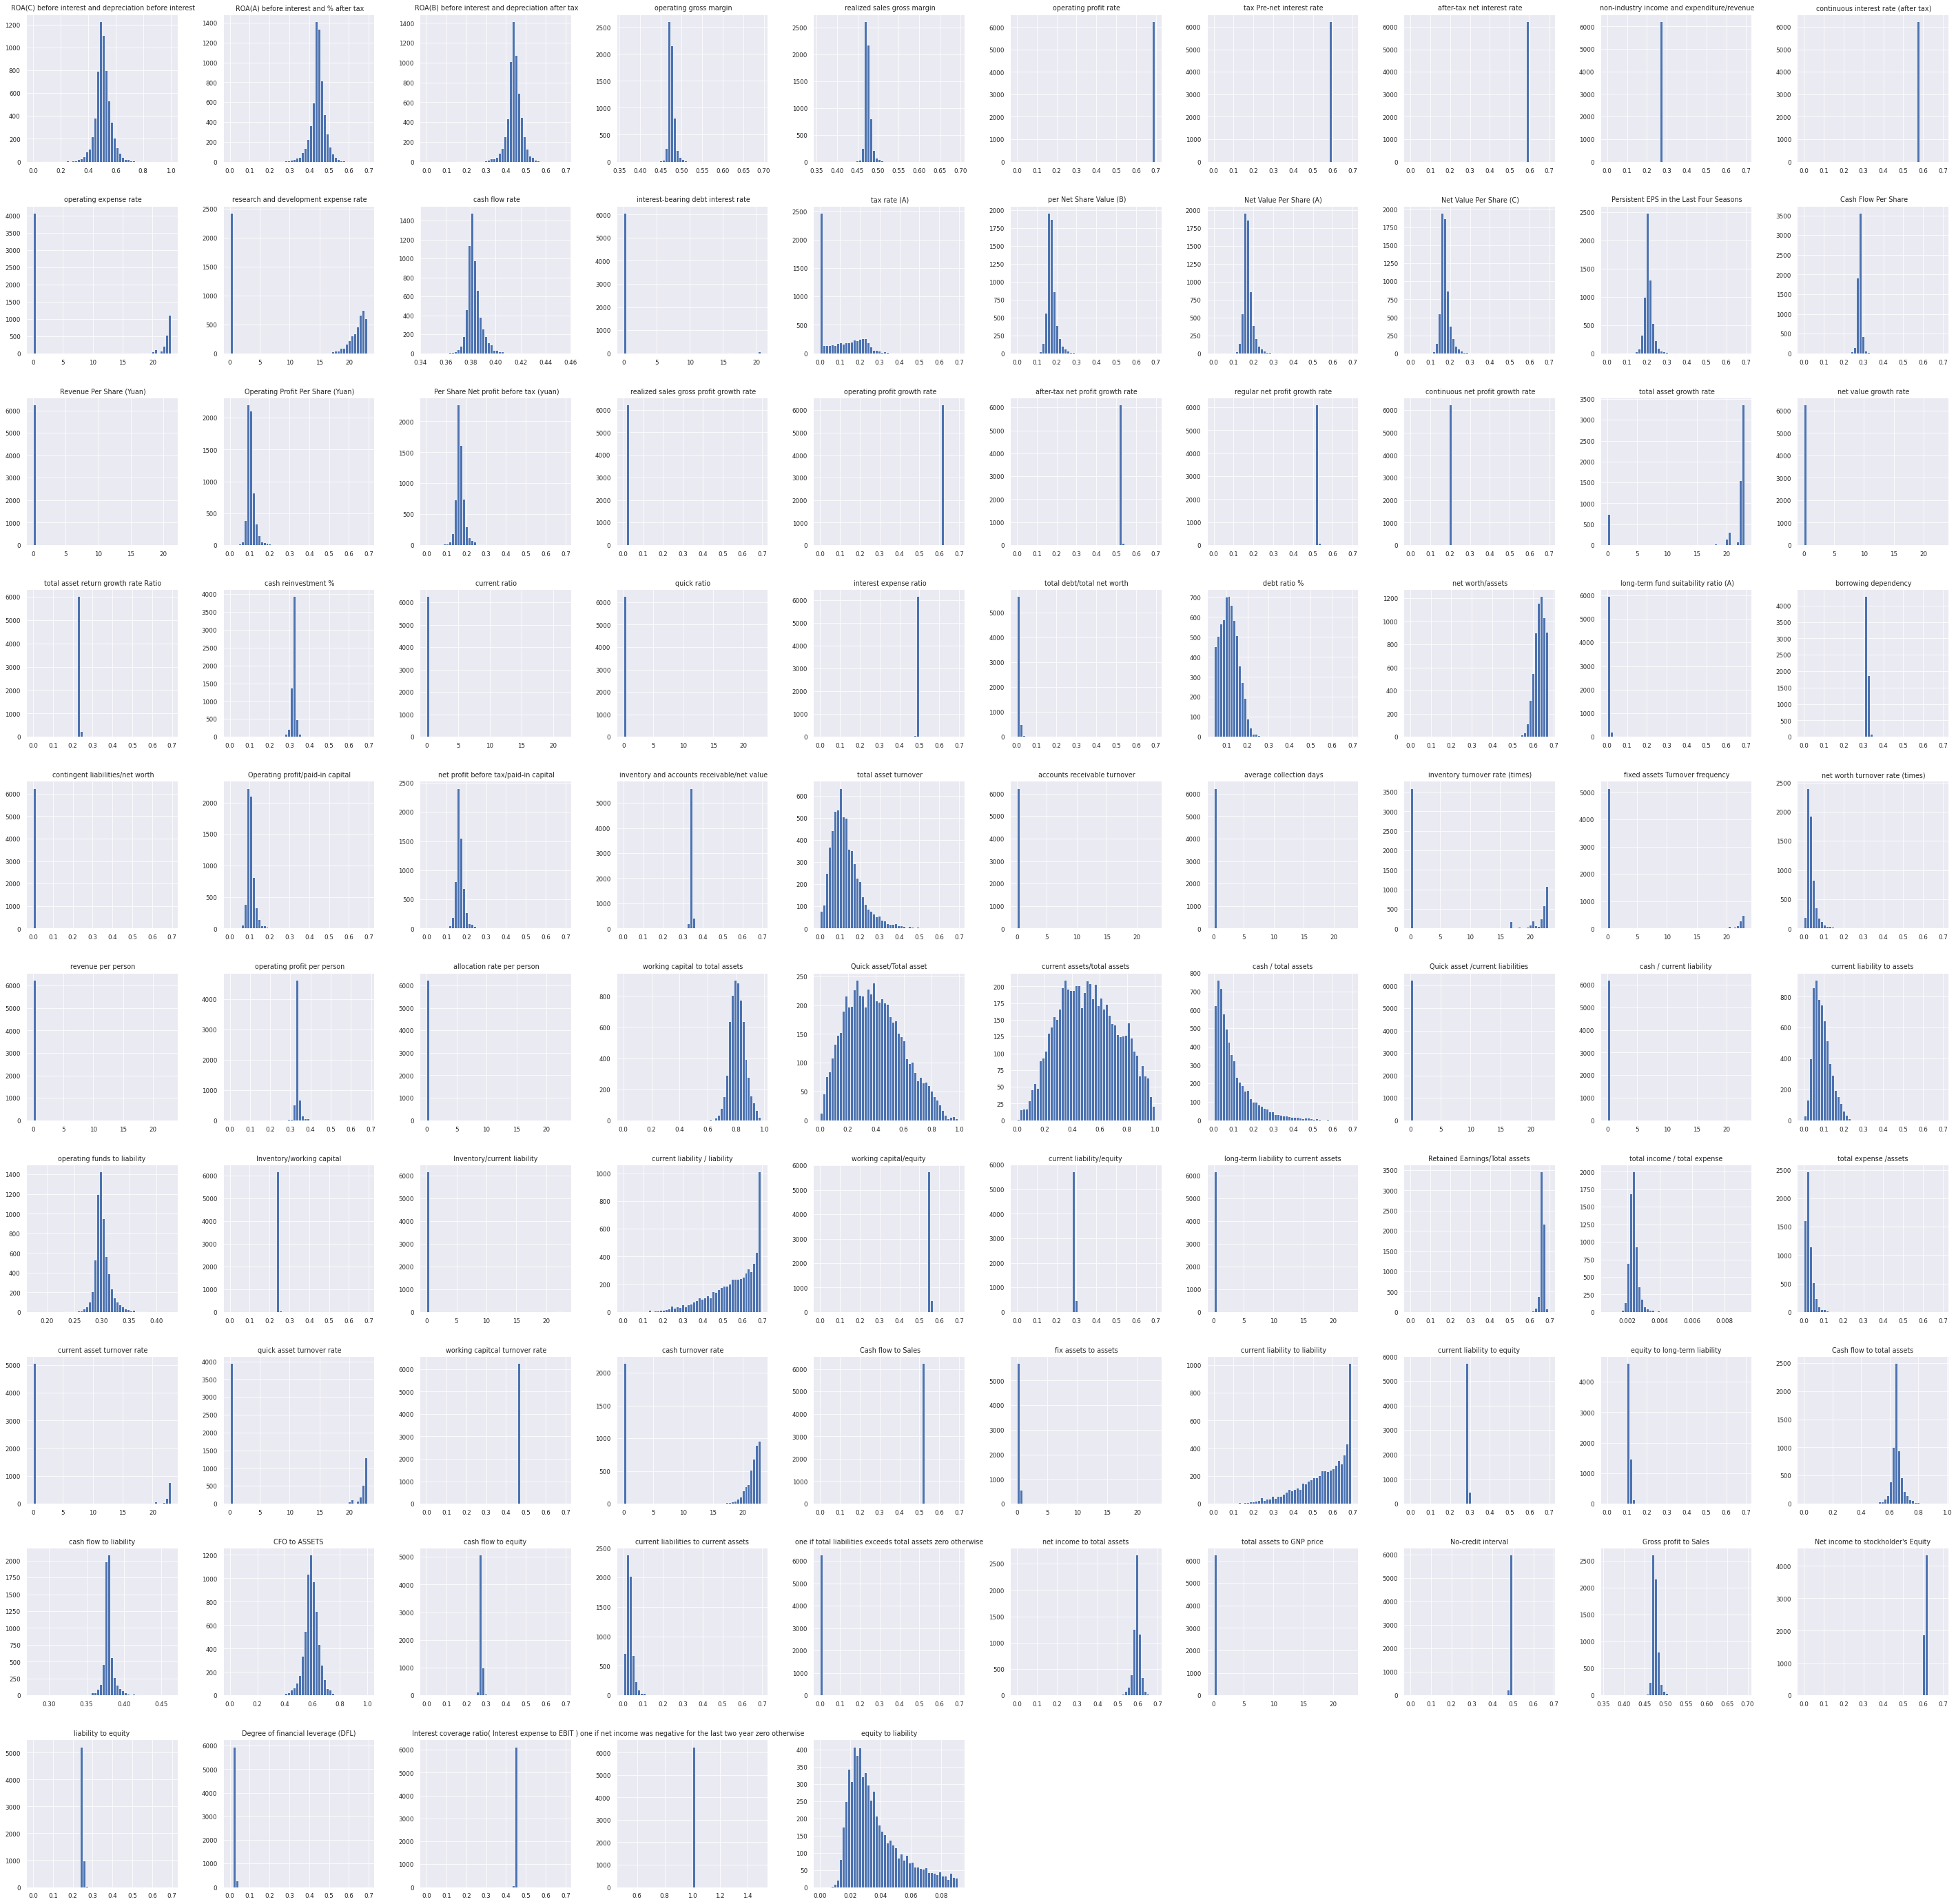

In [ ]:
data_norm.hist(figsize = (50,50),bins = 50)
plt.show()

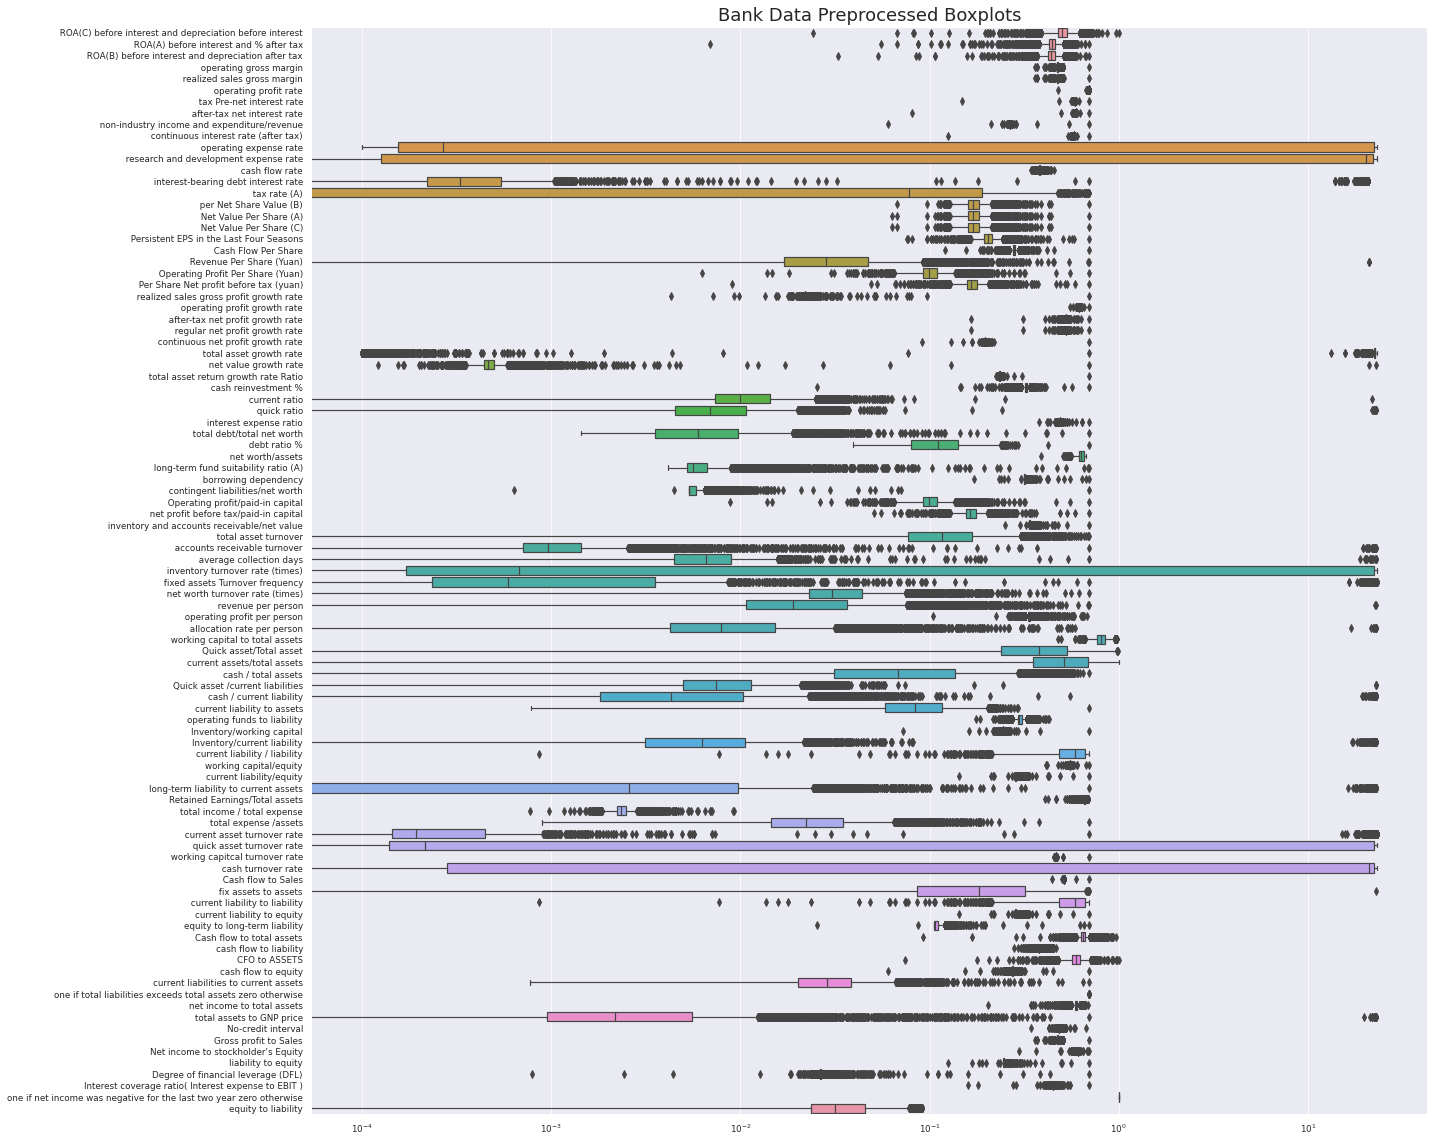

In [ ]:
# Plotting Boxplots of the preprocessed numerical features

plt.figure(figsize = (20,20))
ax =sns.boxplot(data = data_norm, orient="h")
ax.set_title('Bank Data Preprocessed Boxplots', fontsize = 18)
ax.set(xscale="log")
plt.show()

SMOTE: Synthetic Minority Over-sampling Technique 
An approach to the construction of classifiers from imbalanced datasets is described. A dataset is imbalanced if the classification categories are not approximately equally represented.

MODELING
Now, let's see what we can do with our models! We will see the performances on the cleaned undersampled data and on the SMOTE oversampled data. For this part I decided to use a few different models:

1.   Logistic Regression
2.   Randon Forest Classifier
3.   XGBOOST
4.   CatBoost Classifier

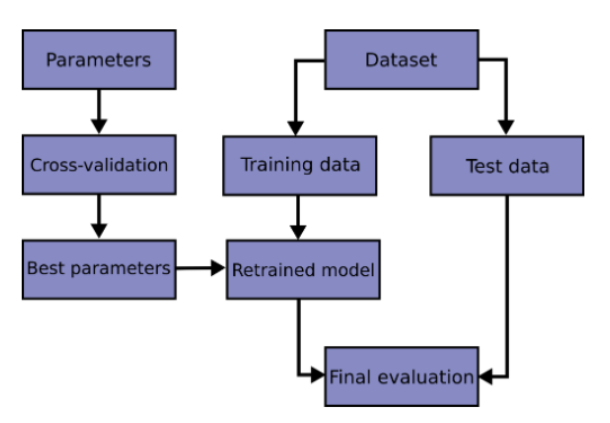

In [ ]:
# Splitting Train and Test Data

X_raw,X_test,y_raw,y_test  = train_test_split(data_norm,
                                              labels,
                                              test_size=0.1,
                                              stratify = labels,
                                              random_state = 42)

In [ ]:
# Stratified Cross Validation Splitting

sss = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)

for train_index, test_index in sss.split(X_raw,y_raw):
    
    print("Train:", train_index, "Test:", test_index)
    X_train_sm, X_val_sm = X_raw.iloc[train_index], X_raw.iloc[test_index]
    y_train_sm, y_val_sm = y_raw.iloc[train_index], y_raw.iloc[test_index]

# Check the Distribution of the labels


# Turn into an array
X_train_sm = X_train_sm.values
X_val_sm = X_val_sm.values
y_train_sm = y_train_sm.values
y_val_sm = y_val_sm.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(y_train_sm, return_counts=True)
test_unique_label, test_counts_label = np.unique(y_val_sm, return_counts=True)
print('-' * 84)

print('Label Distributions: \n')
print(train_counts_label/ len(y_train_sm))
print(test_counts_label/ len(y_val_sm))


Train: [1005 1097 1131 ... 5640 5641 5642] Test: [   0    1    2 ... 1128 1129 1130]
Train: [   0    1    2 ... 5640 5641 5642] Test: [1005 1097 1131 ... 2256 2257 2258]
Train: [   0    1    2 ... 5640 5641 5642] Test: [2224 2259 2260 ... 3384 3385 3438]
Train: [   0    1    2 ... 5640 5641 5642] Test: [3386 3387 3388 ... 4512 4513 4514]
Train: [   0    1    2 ... 4512 4513 4514] Test: [4515 4516 4517 ... 5640 5641 5642]
------------------------------------------------------------------------------------
Label Distributions: 

[0.96522702 0.03477298]
[0.96542553 0.03457447]


**LOGISTIC REGRESSION**

In [ ]:
# List to append the score and then find the average

accuracy_lst_reg = []
precision_lst_reg = []
recall_lst_reg = []
f1_lst_reg = []
auc_lst_reg = []

log_reg_sm = LogisticRegression()
#log_reg_params = {}
log_reg_params = {"penalty": ['l2'],
                  'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                  'class_weight': ['balanced',None],
                  'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)


for train, val in sss.split(X_train_sm, y_train_sm):
    pipeline_reg = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
    model_reg = pipeline_reg.fit(X_train_sm[train], y_train_sm[train])
    best_est_reg = rand_log_reg.best_estimator_
    prediction_reg = best_est_reg.predict(X_train_sm[val])
    
    accuracy_lst_reg.append(pipeline_reg.score(X_train_sm[val], y_train_sm[val]))
    precision_lst_reg.append(precision_score(y_train_sm[val], prediction_reg))
    recall_lst_reg.append(recall_score(y_train_sm[val], prediction_reg))
    f1_lst_reg.append(f1_score(y_train_sm[val], prediction_reg))
    auc_lst_reg.append(roc_auc_score(y_train_sm[val], prediction_reg))


print('---' * 45)
print('')
print('Logistic Regression (SMOTE) results:')
print('')
print("accuracy: {}".format(np.mean(accuracy_lst_reg)))
print("precision: {}".format(np.mean(precision_lst_reg)))
print("recall: {}".format(np.mean(recall_lst_reg)))
print("f1: {}".format(np.mean(f1_lst_reg)))
print('')
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------

Logistic Regression (SMOTE) results:

accuracy: 0.8843853820598007
precision: 0.20067843965691612
recall: 0.7443548387096774
f1: 0.3146118194666689

---------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
# Printing the classification report

label = ['Fin.Stable', 'Fin.Unstable']
pred_reg_sm = best_est_reg.predict(X_val_sm)
print(classification_report(y_val_sm, pred_reg_sm, target_names=label))

              precision    recall  f1-score   support

  Fin.Stable       0.99      0.90      0.94      1089
Fin.Unstable       0.19      0.67      0.30        39

    accuracy                           0.89      1128
   macro avg       0.59      0.78      0.62      1128
weighted avg       0.96      0.89      0.92      1128



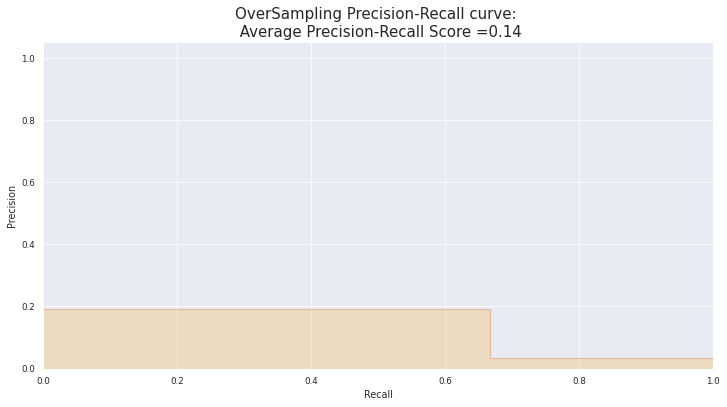

In [ ]:
# Plotting Precision-Recall curve

y_score_reg = best_est_reg.predict(X_val_sm)

average_precision = average_precision_score(y_val_sm, y_score_reg)

fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(y_val_sm, y_score_reg)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=15)

plt.show()


**RANDOM FOREST CLASSIFIER**

In [ ]:
# List to append the score and then find the average

accuracy_lst_rfc = []
precision_lst_rfc = []
recall_lst_rfc = []
f1_lst_rfc = []
auc_lst_rfc = []

rfc_sm = RandomForestClassifier()
#rfc_params = {}
rfc_params = {'max_features' : ['auto', 'sqrt', 'log2'],
              'random_state' : [42],
              'class_weight' : ['balanced','balanced_subsample'],
              'criterion' : ['gini', 'entropy'],
              'bootstrap' : [True,False]}
    
    
rand_rfc = RandomizedSearchCV(rfc_sm, rfc_params, n_iter=4)


for train, val in sss.split(X_train_sm, y_train_sm):
    pipeline_rfc = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_rfc) # SMOTE happens during Cross Validation not before..
    model_rfc = pipeline_rfc.fit(X_train_sm, y_train_sm)
    best_est_rfc = rand_rfc.best_estimator_
    prediction_rfc = best_est_rfc.predict(X_train_sm[val])
    
    accuracy_lst_rfc.append(pipeline_rfc.score(X_train_sm[val], y_train_sm[val]))
    precision_lst_rfc.append(precision_score(y_train_sm[val], prediction_rfc))
    recall_lst_rfc.append(recall_score(y_train_sm[val], prediction_rfc))
    f1_lst_rfc.append(f1_score(y_train_sm[val], prediction_rfc))
    auc_lst_rfc.append(roc_auc_score(y_train_sm[val], prediction_rfc))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst_rfc)))
print("precision: {}".format(np.mean(precision_lst_rfc)))
print("recall: {}".format(np.mean(recall_lst_rfc)))
print("f1: {}".format(np.mean(f1_lst_rfc)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 1.0
precision: 1.0
recall: 1.0
f1: 1.0
---------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
smote_prediction_rfc = best_est_rfc.predict(X_val_sm)
print(classification_report(y_val_sm, smote_prediction_rfc, target_names=label))

              precision    recall  f1-score   support

  Fin.Stable       0.98      0.99      0.98      1089
Fin.Unstable       0.58      0.49      0.53        39

    accuracy                           0.97      1128
   macro avg       0.78      0.74      0.76      1128
weighted avg       0.97      0.97      0.97      1128



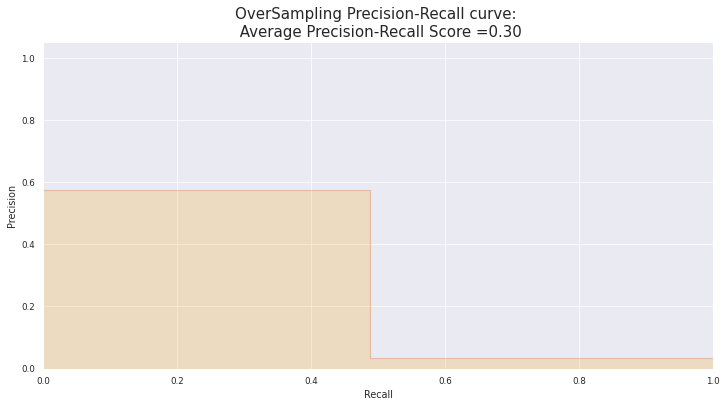

In [ ]:
# Plotting Precision-Recall curve

y_score_rfc = best_est_rfc.predict(X_val_sm)

average_precision_rfc = average_precision_score(y_val_sm, y_score_rfc)

fig = plt.figure(figsize=(12,6))

precision_rfc, recall_rfc, _ = precision_recall_curve(y_val_sm, y_score_rfc)

plt.step(recall_rfc, precision_rfc, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall_rfc, precision_rfc, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision_rfc), fontsize=15)

plt.show()

**XGBOOST**

In [ ]:
# List to append the score and then find the average

accuracy_lst_xgb = []
precision_lst_xgb = []
recall_lst_xgb = []
f1_lst_xgb = []
auc_lst_xgb = []

xgb_sm = xgb.XGBClassifier(random_state = 42)
xgb_params = {'eta' : [0.1,0.01,0.001],  # Learning rate
              'eval_metric': ['logloss'],
              'max_depth' : [3,6,9],
              'lambda' : [1,1.5,2],      # L2 regularization (higher values make model more conservative)
              'alpha' : [0,0.5,1]}        # L1 regularization (higher values make model more conservative)
              #'reg' : ['squarederror']}
              #'random_state': [42]}
        
rand_xgb = RandomizedSearchCV(xgb_sm, xgb_params, n_iter=4)


for train, val in sss.split(X_train_sm, y_train_sm):
    pipeline_xgb = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_xgb) # SMOTE happens during Cross Validation not before..
    model_xgb = pipeline_xgb.fit(X_train_sm, y_train_sm)
    best_est_xgb = rand_xgb.best_estimator_
    prediction_xgb = best_est_xgb.predict(X_train_sm[val])
    
    accuracy_lst_xgb.append(pipeline_xgb.score(X_train_sm[val], y_train_sm[val]))
    precision_lst_xgb.append(precision_score(y_train_sm[val], prediction_xgb))
    recall_lst_xgb.append(recall_score(y_train_sm[val], prediction_xgb))
    f1_lst_xgb.append(f1_score(y_train_sm[val], prediction_xgb))
    auc_lst_xgb.append(roc_auc_score(y_train_sm[val], prediction_xgb))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst_xgb)))
print("precision: {}".format(np.mean(precision_lst_xgb)))
print("recall: {}".format(np.mean(recall_lst_xgb)))
print("f1: {}".format(np.mean(f1_lst_xgb)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 1.0
precision: 1.0
recall: 1.0
f1: 1.0
---------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
# Printing classification report

smote_prediction_xgb = best_est_xgb.predict(X_val_sm)
print(classification_report(y_val_sm, smote_prediction_xgb, target_names=label))

              precision    recall  f1-score   support

  Fin.Stable       0.98      0.98      0.98      1089
Fin.Unstable       0.41      0.49      0.45        39

    accuracy                           0.96      1128
   macro avg       0.70      0.73      0.71      1128
weighted avg       0.96      0.96      0.96      1128



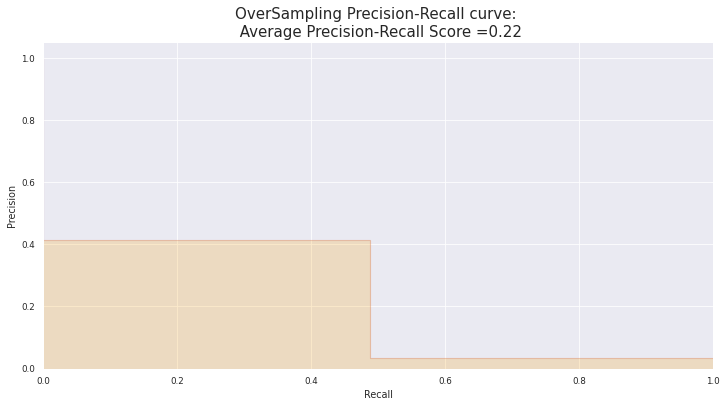

In [ ]:
# Plotting Precision-Recall curve

y_score_xgb = best_est_xgb.predict(X_val_sm)

average_precision_xgb = average_precision_score(y_val_sm, y_score_xgb)

fig = plt.figure(figsize=(12,6))

precision_xgb, recall_xgb, _ = precision_recall_curve(y_val_sm, y_score_xgb)

plt.step(recall_xgb, precision_xgb, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall_xgb, precision_xgb, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision_xgb), fontsize=15)

plt.show()

**CATBOOST**

In [ ]:
# List to append the score and then find the average

accuracy_lst_cat = []
precision_lst_cat = []
recall_lst_cat = []
f1_lst_cat = []
auc_lst_cat = []

cat_sm = CatBoostClassifier(verbose = 0)

cat_params = {'eval_metric': ['F1'],
              'iterations': [100,500,1000],
              'learning_rate' : [0.1,0.01,0.001],
              'random_seed' : [42],
              'auto_class_weights' : ['Balanced','SqrtBalanced']
             }
    
    
rand_cat = RandomizedSearchCV(cat_sm, cat_params, n_iter=4)


for train, val in sss.split(X_train_sm, y_train_sm):
    pipeline_cat = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_cat) # SMOTE happens during Cross Validation not before..
    model_cat = pipeline_cat.fit(X_train_sm, y_train_sm)
    best_est_cat = rand_cat.best_estimator_
    prediction_cat = best_est_cat.predict(X_train_sm[val])
    
    accuracy_lst_cat.append(pipeline_cat.score(X_train_sm[val], y_train_sm[val]))
    precision_lst_cat.append(precision_score(y_train_sm[val], prediction_cat))
    recall_lst_cat.append(recall_score(y_train_sm[val], prediction_cat))
    f1_lst_cat.append(f1_score(y_train_sm[val], prediction_cat))
    auc_lst_cat.append(roc_auc_score(y_train_sm[val], prediction_cat))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst_cat)))
print("precision: {}".format(np.mean(precision_lst_cat)))
print("recall: {}".format(np.mean(recall_lst_cat)))
print("f1: {}".format(np.mean(f1_lst_cat)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.9805094130675526
precision: 0.7253545173341903
recall: 0.9872983870967742
f1: 0.8140949147061203
---------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
smote_prediction_cat = best_est_cat.predict(X_val_sm)
print(classification_report(y_val_sm, smote_prediction_cat, target_names=label))

              precision    recall  f1-score   support

  Fin.Stable       0.98      0.97      0.98      1089
Fin.Unstable       0.40      0.56      0.47        39

    accuracy                           0.96      1128
   macro avg       0.69      0.77      0.72      1128
weighted avg       0.96      0.96      0.96      1128



In [ ]:
feat_imp = best_est_cat.get_feature_importance(prettified=True)
feat_imp

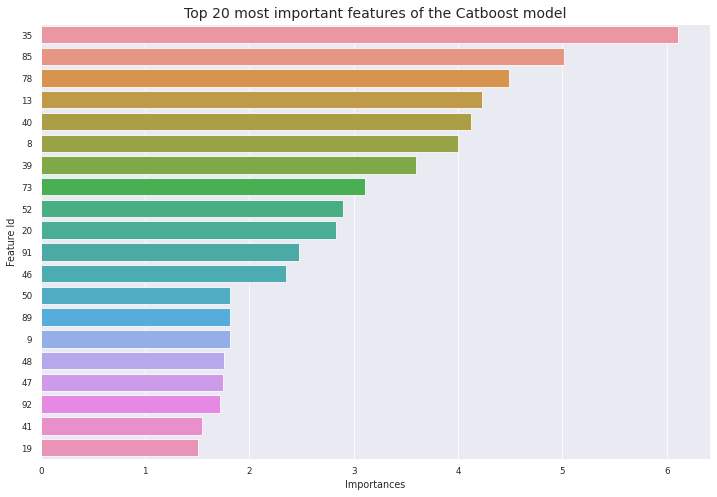

In [ ]:
plt.figure(figsize = (12,8))
sns.barplot(feat_imp['Importances'][:20],feat_imp['Feature Id'][:20], orient = 'h')
plt.title('Top 20 most important features of the Catboost model', fontsize = 14)
plt.show()

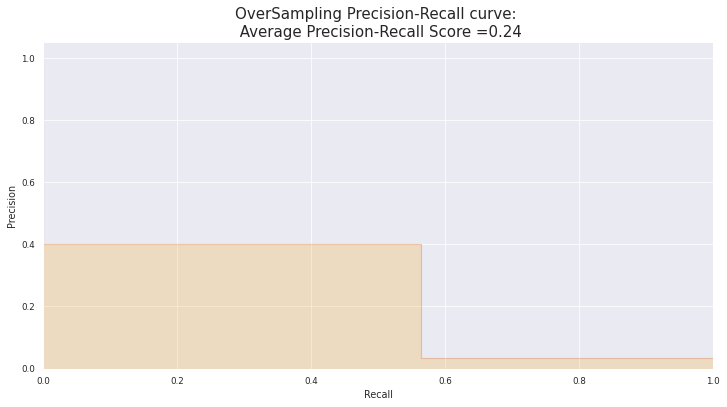

In [ ]:
# Plotting Precision-Recall curve

smote_prediction_cat = best_est_cat.predict(X_val_sm)

average_precision_cat = average_precision_score(y_val_sm, smote_prediction_cat)

fig = plt.figure(figsize=(12,6))

precision_cat, recall_cat, _ = precision_recall_curve(y_val_sm, smote_prediction_cat)

plt.step(recall_cat, precision_cat, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall_cat, precision_cat, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision_cat), fontsize=15)

plt.show()

**RESULTS**

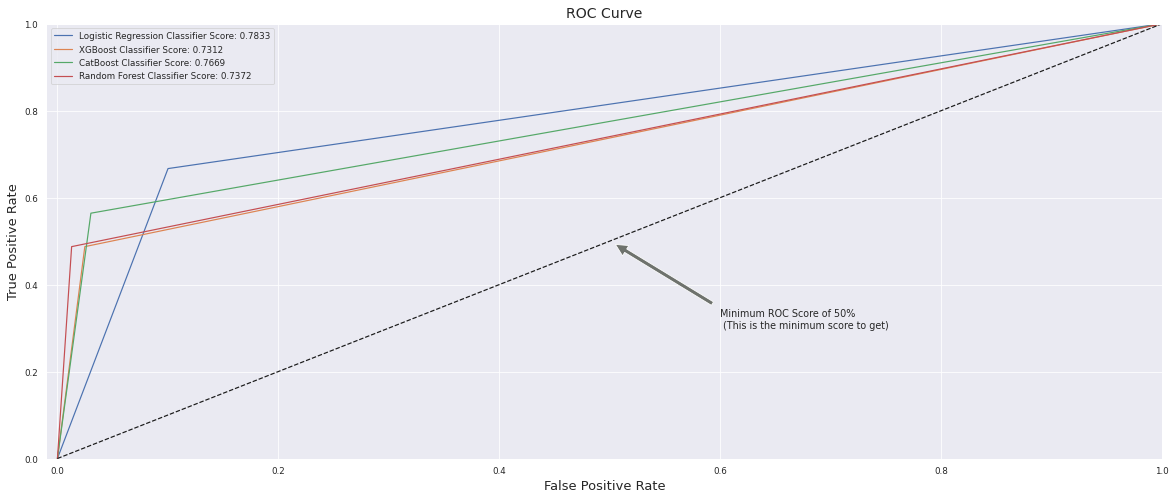

In [ ]:
from sklearn.metrics import roc_curve

log_fpr, log_tpr, log_thresold = roc_curve(y_val_sm, pred_reg_sm)
rfc_fpr, rfc_tpr, rfc_threshold = roc_curve(y_val_sm, smote_prediction_rfc)
xgb_fpr, xgb_tpr, xgb_thresold = roc_curve(y_val_sm, smote_prediction_xgb)
cat_fpr, cat_tpr, cat_thresold = roc_curve(y_val_sm, smote_prediction_cat)


def graph_roc_curve_multiple(log_fpr, log_tpr, rfc_fpr, rfc_tpr,xgb_fpr, xgb_tpr,cat_fpr, cat_tpr):
    plt.figure(figsize=(20,8))
    plt.title('ROC Curve', fontsize=14)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_val_sm, pred_reg_sm)))
    plt.plot(xgb_fpr, xgb_tpr, label='XGBoost Classifier Score: {:.4f}'.format(roc_auc_score(y_val_sm, smote_prediction_xgb)))
    plt.plot(cat_fpr, cat_tpr, label='CatBoost Classifier Score: {:.4f}'.format(roc_auc_score(y_val_sm, smote_prediction_cat)))
    plt.plot(rfc_fpr, rfc_tpr, label='Random Forest Classifier Score: {:.4f}'.format(roc_auc_score(y_val_sm, smote_prediction_rfc)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=13)
    plt.ylabel('True Positive Rate', fontsize=13)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, rfc_fpr, rfc_tpr,xgb_fpr, xgb_tpr,cat_fpr, cat_tpr)
plt.show()


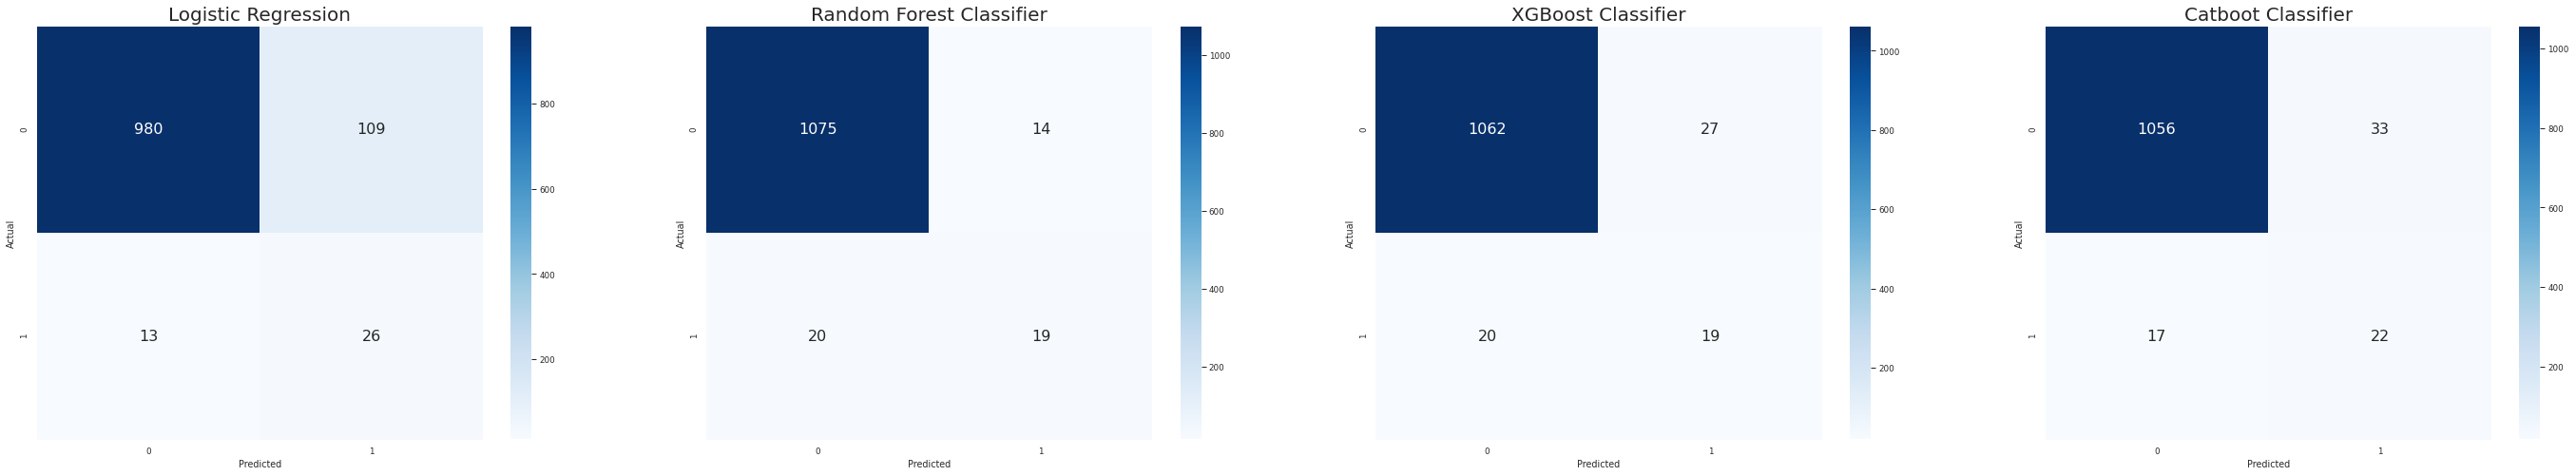

In [ ]:
# Plotting confusion matrix for each classifier

conf_mx0 = confusion_matrix(y_val_sm,pred_reg_sm)
conf_mx1 = confusion_matrix(y_val_sm,smote_prediction_rfc)
conf_mx2 = confusion_matrix(y_val_sm,smote_prediction_xgb)
conf_mx3 = confusion_matrix(y_val_sm,smote_prediction_cat)

heat_cm0 = pd.DataFrame(conf_mx0, columns=np.unique(y_val_sm), index = np.unique(y_val_sm))
heat_cm0.index.name = 'Actual'
heat_cm0.columns.name = 'Predicted'

heat_cm1 = pd.DataFrame(conf_mx1, columns=np.unique(y_val_sm), index = np.unique(y_val_sm))
heat_cm1.index.name = 'Actual'
heat_cm1.columns.name = 'Predicted'

heat_cm2 = pd.DataFrame(conf_mx2, columns=np.unique(y_val_sm), index = np.unique(y_val_sm))
heat_cm2.index.name = 'Actual'
heat_cm2.columns.name = 'Predicted'

heat_cm3 = pd.DataFrame(conf_mx3, columns=np.unique(y_val_sm), index = np.unique(y_val_sm))
heat_cm3.index.name = 'Actual'
heat_cm3.columns.name = 'Predicted'

f, ax = plt.subplots(1, 4, figsize=(20,8))
f.subplots_adjust(left=None, bottom=None, right= 2, top=None, wspace=None, hspace= None)

sns.heatmap(heat_cm0, cmap="Blues", annot=True, annot_kws={"size": 16},fmt='g', ax = ax[0])
ax[0].set_title('Logistic Regression', fontsize = 20)
sns.heatmap(heat_cm1, cmap="Blues", annot=True, annot_kws={"size": 16},fmt='g', ax = ax[1])
ax[1].set_title('Random Forest Classifier', fontsize = 20)
sns.heatmap(heat_cm2, cmap="Blues", annot=True, annot_kws={"size": 16},fmt='g', ax = ax[2])
ax[2].set_title('XGBoost Classifier', fontsize = 20)
sns.heatmap(heat_cm3, cmap="Blues", annot=True, annot_kws={"size": 16},fmt='g', ax = ax[3])
ax[3].set_title('Catboot Classifier', fontsize = 20)

plt.show()

As you can see from the results on validation set, all of our models still have problems in detecting the companies close to bankruptcy. The algorithm that recognizes more observations of the minority class is Logistic Regression, even though this comes with a great cost in term of precision (high presence of false negatives). Despite the presence of the errors, in this case I think that it is better to identify a non close to bankruptcy observation as close to bankrouptcy than vice versa, so it could be a useful model

In [ ]:
# Testing

test_pred_lr = best_est_reg.predict(X_test)
#test_pred_rf = best_est_rfc.predict(X_test)
#test_pred_xgb = best_est_xgb.predict(X_test) 
test_pred_cat = best_est_cat.predict(X_test)

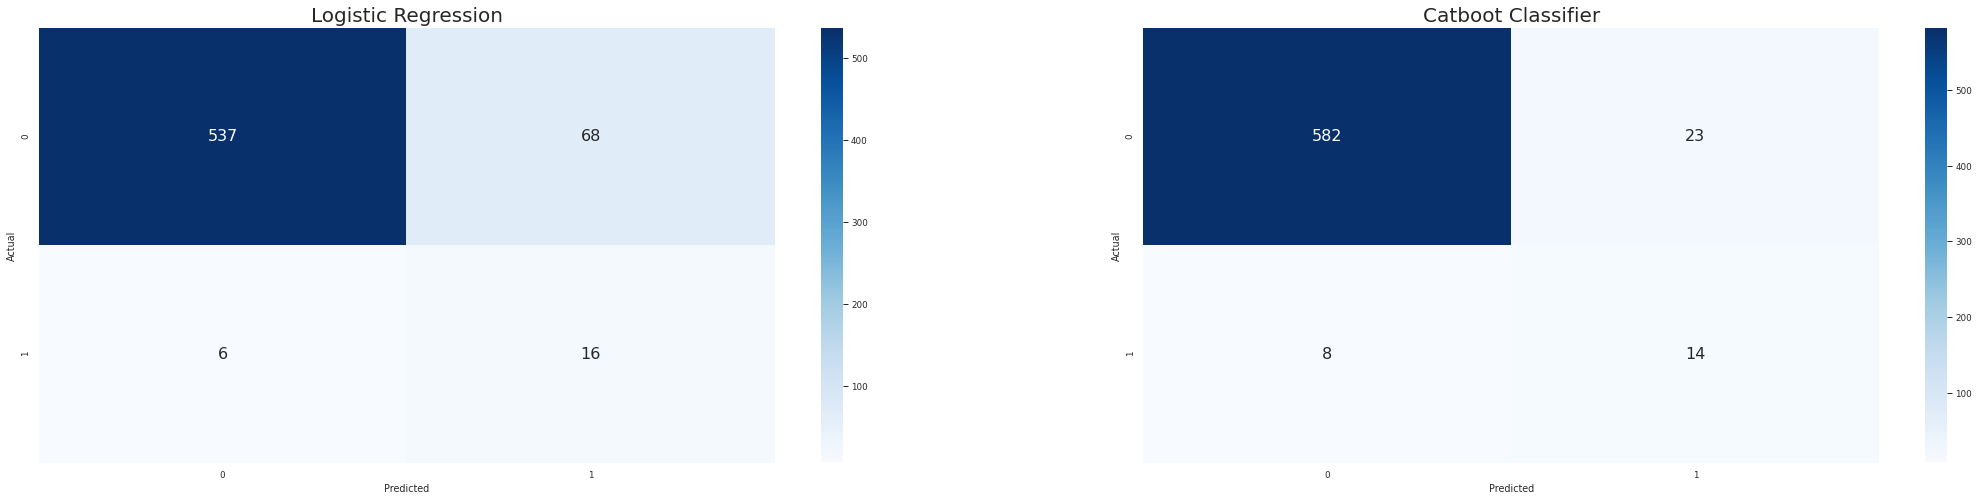

In [ ]:
# Plotting confusion matrix for each classifier

conf_mx0 = confusion_matrix(y_test,test_pred_lr)
conf_mx1 = confusion_matrix(y_test,test_pred_cat)

heat_cm0 = pd.DataFrame(conf_mx0, columns=np.unique(y_test), index = np.unique(y_test))
heat_cm0.index.name = 'Actual'
heat_cm0.columns.name = 'Predicted'

heat_cm1 = pd.DataFrame(conf_mx1, columns=np.unique(y_test), index = np.unique(y_test))
heat_cm1.index.name = 'Actual'
heat_cm1.columns.name = 'Predicted'

f, ax = plt.subplots(1, 2, figsize=(15,8))
f.subplots_adjust(left=None, bottom=None, right= 2, top=None, wspace=None, hspace= None)

sns.heatmap(heat_cm0, cmap="Blues", annot=True, annot_kws={"size": 16},fmt='g', ax = ax[0])
ax[0].set_title('Logistic Regression', fontsize = 20)
sns.heatmap(heat_cm1, cmap="Blues", annot=True, annot_kws={"size": 16},fmt='g', ax = ax[1])
ax[1].set_title('Catboot Classifier', fontsize = 20)

plt.show()


In [ ]:
print(classification_report(y_test, test_pred_lr, target_names=label))

              precision    recall  f1-score   support

  Fin.Stable       0.99      0.89      0.94       605
Fin.Unstable       0.19      0.73      0.30        22

    accuracy                           0.88       627
   macro avg       0.59      0.81      0.62       627
weighted avg       0.96      0.88      0.91       627



In [ ]:
print(classification_report(y_test, test_pred_cat, target_names=label))

              precision    recall  f1-score   support

  Fin.Stable       0.99      0.96      0.97       605
Fin.Unstable       0.38      0.64      0.47        22

    accuracy                           0.95       627
   macro avg       0.68      0.80      0.72       627
weighted avg       0.97      0.95      0.96       627

              precision    recall  f1-score   support

  Fin.Stable       0.99      0.96      0.97       605
Fin.Unstable       0.38      0.64      0.47        22

    accuracy                           0.95       627
   macro avg       0.68      0.80      0.72       627
weighted avg       0.97      0.95      0.96       627



Exactly as shown using validation data we can see how the metric considered (F1) is higher using catboost. Nevertheless, in this case, the best decision is to use Logistic regression because it can better recognize the minority class even misclassifying some not close to bankruptcy companies as close to bankruptcy.